In [ ]:
# -*- coding: utf-8 -*-
"""完整代码"""
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import spearmanr, pearsonr
import time
import os
import pickle
import warnings
import random
from scipy.stats import norm
from scipy.optimize import brentq
import threading
from datetime import datetime, timedelta
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 设置当前日期为最新
current_date = datetime.now().strftime("%Y%m%d")

# 忽略警告
warnings.filterwarnings('ignore')

# 设置Tushare token
ts.set_token("4e250e621fb484356a7b948649e3f1c73d9af358e9ce6a91c1e68a77")
pro = ts.pro_api()

# 缓存路径
CACHE_DIR = "sws_data_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

def get_cached_data(filename, func, *args, **kwargs):
    """获取或缓存数据"""
    filepath = os.path.join(CACHE_DIR, filename)
    
    if os.path.exists(filepath):
        print(f"从缓存加载数据: {filename}")
        with open(filepath, 'rb') as f:
            return pickle.load(f)
    
    print(f"获取新数据: {filename}")
    data = func(*args, **kwargs)
    
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)
    
    return data

def get_sw_industry_list():
    """获取申万一级行业列表"""
    print("正在获取申万一级行业列表...")
    df = pro.index_classify(level='L1', src='SW2021')
    if df is None or df.empty:
        print("未能获取申万一级行业列表。")
        return [], []
    print(f"成功获取 {len(df)} 个申万一级行业。")
    return df['index_code'].tolist(), df['industry_name'].tolist()

def get_industry_daily(industry_codes, start_date, end_date):
    """获取行业日行情数据"""
    all_data = []
    total_industries = len(industry_codes)
    
    for i, code in enumerate(industry_codes):
        try:
            print(f"获取行业数据 [{i+1}/{total_industries}]: {code}")
            
            # 获取行业数据
            df = pro.sw_daily(ts_code=code, start_date=start_date, end_date=end_date, 
                              fields='trade_date,amount,float_mv,close,pct_change')
            if df is None or df.empty:
                print(f" - 未能获取行业 {code} 的数据，跳过。")
                continue
            df['industry_code'] = code
            all_data.append(df)
            
            # 每5个请求后随机延时3-6秒
            if (i + 1) % 5 == 0 and i < total_industries - 1:
                delay = random.uniform(3, 6)
                print(f"已完成 {i+1}/{total_industries}，等待 {delay:.1f} 秒...")
                time.sleep(delay)
                
        except Exception as e:
            print(f" - 获取行业 {code} 数据失败: {e}")
            time.sleep(30)
    
    if all_data:
        return pd.concat(all_data)
    return pd.DataFrame()

def calculate_amt_correlation(df):
    """计算行业成交额占比一致性指标"""
    # 计算相对成交额
    df['relative_amt'] = df['amount'] / df['float_mv']
    
    # 计算每日各行业的相对成交额占比
    daily_total = df.groupby('trade_date')['relative_amt'].sum().reset_index(name='total_relative_amt')
    df = pd.merge(df, daily_total, on='trade_date')
    df['amt_share'] = df['relative_amt'] / df['total_relative_amt']
    
    # 按日期和行业排序，计算排名
    df['rank'] = df.groupby('trade_date')['amt_share'].rank(ascending=False, method='dense')
    
    # 按日期排序
    df = df.sort_values(['trade_date', 'industry_code'])
    
    # 计算每日与前一日排名序列的相关系数
    dates = sorted(df['trade_date'].unique())
    corr_values = []
    
    for i in range(1, len(dates)):
        current_date = dates[i]
        prev_date = dates[i-1]
        
        # 获取当前日期和前一日期的排名数据
        current_ranks = df[df['trade_date'] == current_date][['industry_code', 'rank']].set_index('industry_code')
        prev_ranks = df[df['trade_date'] == prev_date][['industry_code', 'rank']].set_index('industry_code')
        
        # 对齐行业数据
        combined = prev_ranks.join(current_ranks, how='inner', lsuffix='_prev', rsuffix='_curr')
        
        # 计算斯皮尔曼相关系数
        if len(combined) > 1:
            corr, _ = spearmanr(combined['rank_prev'], combined['rank_curr'])
            corr_values.append({'trade_date': current_date, 'amt_corr': corr})
        else:
            corr_values.append({'trade_date': current_date, 'amt_corr': np.nan})
    
    corr_df = pd.DataFrame(corr_values)
    
    # 计算20日均线和20日标准差
    corr_df['amt_corr_ma'] = corr_df['amt_corr'].rolling(20).mean()  # 修正列名
    corr_df['amt_corr_std'] = corr_df['amt_corr'].rolling(20).std()
    corr_df['amt_corr_std_ma'] = corr_df['amt_corr_std'].rolling(20).mean()
    
    return corr_df, df

def calculate_industry_concentration(industry_data):
    """计算行业集中度指标"""
    if industry_data.empty:
        return pd.DataFrame()

    # 计算每日行业集中度
    concentration_data = []
    
    for trade_date, group in industry_data.groupby('trade_date'):
        if len(group) < 5:
            concentration_data.append({'trade_date': trade_date, 'concentration': np.nan})
            continue
        
        # 获取换手率前五的行业
        top5 = group.nlargest(5, 'relative_amt')
        top5_avg = top5['relative_amt'].mean()
        
        # 计算全市场平均换手率
        market_avg = group['relative_amt'].mean()
        
        # 计算集中度
        if market_avg == 0:
            concentration_data.append({'trade_date': trade_date, 'concentration': np.nan})
        else:
            concentration = top5_avg / market_avg
            concentration_data.append({'trade_date': trade_date, 'concentration': concentration})
    
    conc_df = pd.DataFrame(concentration_data)
    
    # 计算20日均线
    conc_df['concentration_ma20'] = conc_df['concentration'].rolling(20).mean()
    
    return conc_df

def calculate_return_amt_correlation(industry_data):
    """计算行业涨幅和成交额变化一致性指标"""
    if industry_data.empty:
        return pd.DataFrame()

    # 计算相对成交额
    industry_data['relative_amt'] = industry_data['amount'] / industry_data['float_mv'].replace(0, np.nan)
    
    # 计算日收益率
    industry_data = industry_data.sort_values(['industry_code', 'trade_date'])
    industry_data['return'] = industry_data.groupby('industry_code')['close'].pct_change()
    industry_data = industry_data.dropna(subset=['return', 'relative_amt'])

    # 按日期分组计算相关性
    return_amt_corr = []
    
    for date, group in industry_data.groupby('trade_date'):
        if len(group) < 2:
            return_amt_corr.append({'trade_date': date, 'return_amt_corr': np.nan})
            continue

        # 计算排名
        group['return_rank'] = group['return'].rank(ascending=False, method='dense')
        group['relative_amt_rank'] = group['relative_amt'].rank(ascending=False, method='dense')
        
        # 计算相关系数
        if len(group['return_rank']) > 1:
            corr, _ = spearmanr(group['return_rank'], group['relative_amt_rank'])
            return_amt_corr.append({'trade_date': date, 'return_amt_corr': corr})
        else:
            return_amt_corr.append({'trade_date': date, 'return_amt_corr': np.nan})
    
    corr_df = pd.DataFrame(return_amt_corr)
    
    # 计算60日均线
    corr_df['return_amt_corr_ma60'] = corr_df['return_amt_corr'].rolling(60).mean()
    
    return corr_df

def calculate_gem_activity(start_date, end_date):
    """创业板成交活跃度"""
    print("正在获取创业板成交活跃度数据...")
    
    # 1. 获取创业板成交额（399006.SZ）
    gem = pro.index_daily(ts_code='399006.SZ', 
                          start_date=start_date, 
                          end_date=end_date,
                          fields='trade_date,amount')
    if gem is None or gem.empty:
        print("警告：未获取到创业板成交额数据")
        return pd.DataFrame()
    gem.columns = ['trade_date', 'amount_gem']
    
    # 2. 获取全市场A股成交额（使用daily表，包含所有股票）
    all_a = pro.daily(trade_date='', 
                      start_date=start_date, 
                      end_date=end_date,
                      fields='trade_date,amount')
    if all_a is None or all_a.empty:
        print("警告：未获取到全市场成交额数据")
        return pd.DataFrame()
    all_a = all_a.groupby('trade_date')['amount'].sum().reset_index()
    all_a.columns = ['trade_date', 'amount_all']
    
    # 3. 外连接合并数据（保留所有日期）
    merged = pd.merge(gem, all_a, on='trade_date', how='outer')
    
    # 4. 计算创业板成交活跃度（处理除零和缺失值）
    merged['gem_activity'] = merged['amount_gem'] / merged['amount_all'].replace(0, np.nan)
    merged['gem_activity'] = merged['gem_activity'].fillna(method='ffill')  # 向前填充
    merged = merged.dropna(subset=['gem_activity'])
    
    # 5. 计算20日均线（报告中使用20日均线）
    merged['gem_activity_ma20'] = merged['gem_activity'].rolling(20).mean()
    
    # 6. 筛选报告时间范围（2017-2024）
    report_start = pd.to_datetime('20170103')
    merged = merged[pd.to_datetime(merged['trade_date']) >= report_start]
    
    return merged[['trade_date', 'gem_activity', 'gem_activity_ma20']]

# 图9：融资余额占流通市值比
def calculate_margin_ratio(start_date, end_date):
    print("计算融资余额占比...")
    
    margin = pro.margin(start_date=start_date, end_date=end_date, fields='trade_date,rzye')
    if margin.empty:
        return pd.DataFrame()

    # 存储结果
    offset = 0
    all_data = []
    while True:
        df = pro.daily_basic(start_date=start_date, end_date=end_date, fields='trade_date,circ_mv', limit=6000, offset=offset)
        if df.empty:
            break
        all_data.append(df)
        offset += 6000
        time.sleep(0.5)  # 避免请求过快

    # 合并所有分页数据
    market_val = pd.concat(all_data, ignore_index=True)
    market_val.sort_values('trade_date', inplace=True)

    if market_val.empty:
        return pd.DataFrame()

    # 统一单位：rzye 是元，circ_mv 是万元
    market_val['circ_mv'] = market_val['circ_mv'] * 10000

    # 合并数据并按日期排序
    merged = pd.merge(margin, market_val, on='trade_date', how='inner')
    merged = merged.sort_values('trade_date')

    merged['margin_ratio'] = merged['rzye'] / merged['circ_mv'].replace(0, np.nan)
    merged['margin_ratio'] = merged['margin_ratio'].fillna(method='ffill')
    
    # 计算60日均线
    merged['margin_ratio_ma60'] = merged['margin_ratio'].rolling(60).mean()
    
    return merged[['trade_date', 'margin_ratio', 'margin_ratio_ma60']]


def calculate_industry_rotation(industry_data):
    """计算行业轮涨补涨程度指标"""
    if industry_data.empty:
        return pd.DataFrame()

    # 直接使用涨跌幅
    # 按日期和行业排序
    industry_data = industry_data.sort_values(['trade_date', 'industry_code'])
    
    # 计算轮动相关性
    rotation_data = []
    dates = sorted(industry_data['trade_date'].unique())
    
    for i in range(1, len(dates)):
        current_date = dates[i]
        prev_date = dates[i-1]
        
        # 获取当前日期和前一日期的行业涨跌幅
        current_data = industry_data[industry_data['trade_date'] == current_date][['industry_code', 'pct_change']]
        prev_data = industry_data[industry_data['trade_date'] == prev_date][['industry_code', 'pct_change']]
        
        # 合并数据
        merged = pd.merge(prev_data, current_data, on='industry_code', suffixes=('_prev', '_curr'), how='inner')
        
        if len(merged) < 2:
            rotation_data.append({'trade_date': current_date, 'rotation_corr': np.nan})
            continue

        # 直接使用涨跌幅计算排名
        merged['rank_prev'] = merged['pct_change_prev'].rank(ascending=False, method='dense')
        merged['rank_curr'] = merged['pct_change_curr'].rank(ascending=False, method='dense')

        # 计算排名相关系数
        if len(merged['rank_prev']) > 1:
            corr, _ = spearmanr(merged['rank_prev'], merged['rank_curr'])
            rotation_data.append({'trade_date': current_date, 'rotation_corr': corr})
        else:
            rotation_data.append({'trade_date': current_date, 'rotation_corr': np.nan})
    
    rotation_df = pd.DataFrame(rotation_data)
    
    # 计算20日均线
    rotation_df['rotation_corr_ma20'] = rotation_df['rotation_corr'].rolling(20).mean()
    
    return rotation_df

def calculate_hs300_rsi(start_date, end_date, window=14):
    """计算沪深300 RSI指标"""
    print("正在获取沪深300指数数据计算RSI...")
    # 获取沪深300指数数据
    hs300 = pro.index_daily(ts_code='000300.SH', start_date=start_date, end_date=end_date,
                            fields='trade_date,close')
    
    if hs300 is None or hs300.empty:
        return pd.DataFrame()

    # 确保数据按日期排序
    hs300 = hs300.sort_values('trade_date')

    # 计算日收益率
    hs300['return'] = hs300['close'].pct_change()
    
    # 计算涨跌幅
    hs300['gain'] = np.where(hs300['return'] > 0, hs300['return'], 0)
    hs300['loss'] = np.where(hs300['return'] < 0, abs(hs300['return']), 0)
    
    # 计算平均增益和平均损失
    hs300['avg_gain'] = hs300['gain'].rolling(window=window, min_periods=1).mean()
    hs300['avg_loss'] = hs300['loss'].rolling(window=window, min_periods=1).mean()
    
    # 计算相对强度 (RS)
    hs300['rs'] = hs300['avg_gain'] / hs300['avg_loss'].replace(0, np.nan)
    
    # 计算RSI
    hs300['rsi'] = 100 - (100 / (1 + hs300['rs']))
    
    # 计算20日均线
    hs300['rsi_ma20'] = hs300['rsi'].rolling(20).mean()
    
    return hs300[['trade_date', 'rsi', 'rsi_ma20']]

def get_hs300_data(start_date, end_date):
    """获取沪深300指数数据"""
    print("正在获取沪深300指数数据...")
    df = pro.index_daily(ts_code='000300.SH', start_date=start_date, end_date=end_date,
                         fields='trade_date,close')
    
    if df is None or df.empty:
        return pd.DataFrame()

    # 确保数据按日期排序
    df = df.sort_values('trade_date')
    
    # 找到基准日期的数据
    start_value = df[df['trade_date'] == '20170103']['close'].values[0] if '20170103' in df['trade_date'].values else df.iloc[0]['close']
        
    df['nav'] = df['close'] / start_value
    return df[['trade_date', 'nav', 'close']]

def calculate_correlation(df, indicator_col, price_col, start_date, end_date):
    """计算指标与价格的相关性"""
    if df.empty:
        return np.nan

    # 筛选日期范围
    filtered = df[(df['trade_date'] >= start_date) & (df['trade_date'] <= end_date)]
    
    # 检查相关列是否存在
    if indicator_col not in filtered.columns or price_col not in filtered.columns:
        return np.nan

    # 删除缺失值
    filtered = filtered.dropna(subset=[indicator_col, price_col])
    
    if len(filtered) < 2:
        return np.nan
    
    # 计算皮尔逊相关系数
    corr, _ = pearsonr(filtered[indicator_col], filtered[price_col])
    
    return corr

def plot_chart(data, hs300, title, ylabel_left, ylabel_right, 
               indicator_col, nav_col='nav', corr_value=None,
               ylim_left=None, ylim_right=None, figsize=(14, 8),
               plot_start_date=None, plot_end_date=None):
    """绘制指标与沪深300净值的双轴图"""
    # 合并数据
    merged = pd.merge(data, hs300, on='trade_date', how='inner')
    
    # 转换为日期格式
    merged['trade_date'] = pd.to_datetime(merged['trade_date'])
    merged = merged.set_index('trade_date').dropna()
    
    if merged.empty:
        print(f"警告：合并后的数据为空，无法绘制图表: {title}")
        return

    # 根据日期筛选数据
    if plot_start_date and plot_end_date:
        merged = merged[(merged.index >= pd.to_datetime(plot_start_date)) & 
                        (merged.index <= pd.to_datetime(plot_end_date))]
    
    if merged.empty:
        return

    # 创建图表
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # 绘制指标
    ax1.plot(merged.index, merged[indicator_col], 
             label=ylabel_left, 
             color='#1f77b4', linewidth=2.5)
    ax1.set_xlabel('日期', fontsize=12)
    ax1.set_ylabel(ylabel_left, color='#1f77b4', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='#1f77b4')
    if ylim_left:
        ax1.set_ylim(ylim_left)
    
    # 绘制沪深300净值
    ax2 = ax1.twinx()
    ax2.plot(merged.index, merged[nav_col], 
             label=ylabel_right, 
             color='#ff7f0e', alpha=0.9, linewidth=2.5)
    ax2.set_ylabel(ylabel_right, color='#ff7f0e', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='#ff7f0e')
    if ylim_right:
        ax2.set_ylim(ylim_right)
    
    # 设置日期格式
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax1.xaxis.set_major_locator(mdates.YearLocator()) 
    ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))

    # 添加标题
    plt.title(title, fontsize=14, fontweight='bold')
    
    # 添加图例
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
    
    # 添加网格
    ax1.grid(True, linestyle='--', alpha=0.4)
    
    # 添加数据来源
    plt.figtext(0.85, 0.01, '资料来源：Tushare，申万宏源研究', ha='center', fontsize=9)
    
    # 添加相关系数
    if corr_value is not None and not np.isnan(corr_value):
        plt.figtext(0.15, 0.85, f"与沪深300价格指数的相关系数: {corr_value:.2f}", 
                    ha='left', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    filename = title.replace(' ', '_').replace(':', '').replace('/', '_') + '.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"图表已保存为: {filename}")
    plt.show()
    plt.close()

def black_scholes_iv(S, K, T, r, option_type, price):
    """使用Black-Scholes模型计算隐含波动率"""
    def black_scholes(sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == 'call':
            return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2) - price
        else:  # put
            return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1) - price
    
    try:
        # 使用布伦特方法求解隐含波动率
        return brentq(black_scholes, 1e-6, 5.0, xtol=1e-4)
    except:
        return np.nan

def calculate_vix_for_date(option_data, underlying_price, trade_date):
    """计算某一交易日的VIX指数"""
    today = pd.to_datetime(trade_date)
    
    # 筛选出两个最近到期月份
    expiries = option_data['maturity_date'].unique()
    if len(expiries) < 2:
        return np.nan
    
    # 按距离排序到期日
    expiries.sort()
    near_expiry = expiries[0]
    next_expiry = expiries[1]
    
    # 计算两个到期日的时间（年）
    T1 = (near_expiry - today).days / 365.0
    T2 = (next_expiry - today).days / 365.0
    
    # 筛选出两个到期日的看涨和看跌期权
    near_options = option_data[option_data['maturity_date'] == near_expiry]
    next_options = option_data[option_data['maturity_date'] == next_expiry]
    
    # 找到最接近平价的期权（执行价最接近标的当前价格）
    def find_atm_options(options):
        if options.empty:
            return pd.DataFrame()
        options['moneyness'] = abs(options['exercise_price'] - underlying_price)
        return options.sort_values('moneyness').head(4)  # 每个月份取4个（2个call，2个put）
    
    near_atm = find_atm_options(near_options)
    next_atm = find_atm_options(next_options)
    
    if near_atm.empty or next_atm.empty:
        return np.nan
    
    # 计算隐含波动率
    near_atm['iv'] = near_atm.apply(
        lambda row: black_scholes_iv(
            underlying_price, row['exercise_price'], T1, 0.03, row['call_put'], row['close']
        ), axis=1
    )
    next_atm['iv'] = next_atm.apply(
        lambda row: black_scholes_iv(
            underlying_price, row['exercise_price'], T2, 0.03, row['call_put'], row['close']
        ), axis=1
    )
    
    # 计算两个期限的平均隐含波动率
    near_avg_iv = near_atm['iv'].mean()
    next_avg_iv = next_atm['iv'].mean()
    
    # 计算VIX（加权平均）
    w = (T2 - 30/365) / (T2 - T1)  # 权重因子，假设30天为基准
    vix = w * near_avg_iv + (1 - w) * next_avg_iv
    return vix * 100  # 转换为百分比形式

def get_option_data(ts_code, start_date, end_date):
    """获取期权数据（包括基础信息和日行情）"""
    # 获取期权合约基础信息
    basic = pro.opt_basic(exchange='SSE', fields='ts_code,name,exercise_price,call_put,list_date,delist_date,maturity_date')
    
    # 过滤标的
    if '50' in ts_code:
        basic = basic[basic['name'].str.contains('50ETF')]
    else:
        basic = basic[basic['name'].str.contains('沪深300')]
    
    if basic.empty:
        return pd.DataFrame()
    


    # 获取期权日行情
    all_daily = []
    # for code in tqdm(basic['ts_code'], desc="下载期权日线数据"):
    #     try:
    #         daily = pro.opt_daily(ts_code=code, start_date=start_date, end_date=end_date, fields='trade_date,ts_code,close')
    #         all_daily.append(daily)
    #         # break
    #     except:
    #         print("error")
    #         time.sleep(2)  # 避免请求过快
    #         continue
    
    start_date_dt = datetime.strptime(start_date, "%Y%m%d")
    end_date_dt = datetime.strptime(end_date, "%Y%m%d")
    current_date = start_date_dt
    while current_date <= end_date_dt:
        try:
            # 格式化为YYYYMMDD字符串
            date_str = current_date.strftime("%Y%m%d")
            daily = pro.opt_daily(exchange='SSE', start_date=date_str, end_date=date_str, fields='trade_date,ts_code,close')
            all_daily.append(daily)

            # 日期递增
            current_date += timedelta(days=1)
        except:
            print("time sleep 15s")
            time.sleep(15)
            continue
    
    if not all_daily:
        return pd.DataFrame()
    
    daily_df = pd.concat(all_daily, ignore_index=True)
    
    # 合并基础信息
    merged = pd.merge(daily_df, basic, on='ts_code')
    
    # 转换日期
    merged['trade_date'] = pd.to_datetime(merged['trade_date'])
    merged['maturity_date'] = pd.to_datetime(merged['maturity_date'])
    
    # 过滤标的
    if '50' in ts_code:
        merged = merged[merged['name'].str.contains('50ETF')]
    else:
        merged = merged[merged['name'].str.contains('沪深300')]
    
    return merged[['trade_date', 'ts_code', 'close', 'exercise_price', 'call_put', 'maturity_date']]

def get_vix_data(ts_code, start_date, end_date):
    """计算VIX指数"""
    print(f"开始计算 {ts_code} 的VIX指数，日期范围：{start_date} 至 {end_date}")
    
    # 获取标的物价格
    if '50' in ts_code:
        # 50ETF
        underlying_code = '510050.SH'
        underlying_data = pro.fund_daily(ts_code=underlying_code, 
                                        start_date=start_date, 
                                        end_date=end_date,
                                        fields='trade_date,close')
    else:
        # 沪深300ETF（上交所）
        underlying_code = '510300.SH'
        underlying_data = pro.fund_daily(ts_code=underlying_code,
                                        start_date=start_date,
                                        end_date=end_date,
                                        fields='trade_date,close')
    
    print(f"获取到 {len(underlying_data)} 条标的物数据")
    
    underlying_data['trade_date'] = pd.to_datetime(underlying_data['trade_date'])
    underlying_data = underlying_data.set_index('trade_date')['close']
    
    # 获取期权数据
    option_data = get_option_data(ts_code, start_date, end_date)
    print(f"获取到 {len(option_data)} 条期权数据")
    
    if option_data.empty:
        print("警告：没有获取到期权数据")
        return pd.DataFrame()
    
    # 计算每日VIX
    vix_values = []
    dates = pd.date_range(start=start_date, end=end_date, freq='B')
    
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = []
        for trade_date in dates:
            if trade_date in underlying_data.index:
                print(f"\n处理日期：{trade_date.strftime('%Y%m%d')}")
                underlying_price = underlying_data.loc[trade_date]
                print(f"标的物价格：{underlying_price}")
                
                date_options = option_data[option_data['trade_date'] == trade_date]
                print(f"该日期有 {len(date_options)} 个期权合约")
                
                if len(date_options) >= 8:
                    futures.append(executor.submit(
                        calculate_vix_for_date, date_options, underlying_price, trade_date
                    ))
                else:
                    print("警告：合约数量不足8个，跳过计算")
        
        for i, future in enumerate(futures):
            if i % 10 == 0:
                print(f"计算VIX进度: {i+1}/{len(futures)}")
            try:
                vix = future.result()
                if vix is not None:
                    vix_values.append({
                        'trade_date': dates[i].strftime("%Y%m%d"),
                        'vix': vix
                    })
            except Exception as e:
                print(f"计算VIX时出错：{str(e)}")
    
    if not vix_values:
        print("警告：未能计算出任何VIX值")
        return pd.DataFrame()
    
    return pd.DataFrame(vix_values)

def get_50etf_vix_data(start_date, end_date):
    """获取50ETF波指数据"""
    return get_cached_data(
        f"vix_50etf_{start_date}_{end_date}.pkl",
        get_vix_data,
        '50ETF', start_date, end_date
    )

def get_300_vix_data(start_date, end_date):
    """获取300波指数据"""
    return get_cached_data(
        f"vix_300_{start_date}_{end_date}.pkl",
        get_vix_data,
        '300', start_date, end_date
    )

def get_50etf_price(start_date, end_date):
    """获取50ETF价格数据"""
    df = pro.fund_daily(ts_code='510050.SH', start_date=start_date, end_date=end_date,
                       fields='trade_date,close')
    df = df.rename(columns={'close': 'price_50etf'})
    df['trade_date'] = pd.to_datetime(df['trade_date'])
    df['trade_date'] = df['trade_date'].dt.strftime('%Y%m%d')
    return df[['trade_date', 'price_50etf']]

def get_hs300_index(start_date, end_date):
    """获取沪深300指数数据"""
    df = pro.index_daily(ts_code='000300.SH', start_date=start_date, end_date=end_date,
                        fields='trade_date,close')
    df = df.rename(columns={'close': 'price_hs300'})
    df['trade_date'] = pd.to_datetime(df['trade_date'])
    df['trade_date'] = df['trade_date'].dt.strftime('%Y%m%d')
    return df[['trade_date', 'price_hs300']]

class TushareRateController:
    """Tushare API请求速率控制器"""
    def __init__(self, max_per_minute=140):
        """
        :param max_per_minute: 每分钟最大请求数
        """
        self.max_requests = max_per_minute
        self.request_times = []
        self.lock = threading.Lock()
    
    def wait_for_slot(self):
        """等待可用的请求名额"""
        with self.lock:
            # 清理超时请求记录（60秒窗口）
            now = time.time()
            self.request_times = [t for t in self.request_times if now - t < 60]
            
            # 检查当前请求数
            if len(self.request_times) >= self.max_requests:
                # 计算最早请求的剩余时间
                oldest_time = self.request_times[0]
                wait_time = 60 - (now - oldest_time)
                if wait_time > 0:
                    time.sleep(wait_time + 0.5)  # 额外0.5秒缓冲
                    # 更新请求时间列表
                    self.request_times = [t for t in self.request_times if now - t < 60]
            
            # 记录本次请求时间
            self.request_times.append(time.time())

def get_300_option_data_corrected(start_date, end_date):
    """严格限速的沪深300期权数据获取"""
    if os.path.exists("300_option_data"):
        with open("300_option_data", 'rb') as f:
            all_data = pickle.load(f)
    else:
        # 初始化速率控制器（留10%缓冲空间）
        rate_controller = TushareRateController(max_per_minute=135)
        
        # 获取合约基本信息（含call_put字段）
        contracts = pro.opt_basic(
            exchange='CFFEX', 
            opt_type='I',
            fields='ts_code,call_put'
        )
        print(f"获取到 {len(contracts)} 个沪深300股指期权合约")
        
        # 按到期月份分组处理（减少单次请求压力）
        contracts['expiry_month'] = contracts['ts_code'].apply(lambda x: x.split('-')[1])
        grouped_contracts = contracts.groupby('expiry_month')
        
        all_data = []
        processed_contracts = 0
        total_contracts = len(contracts)
        
        # 分批处理合约组
        for month, group in grouped_contracts:
            print(f"处理 {month} 月份合约组 ({len(group)} 个合约)")

            max_retries = 3  # 最大重试次数
            retry_delay = 60  # 重试等待时间（秒）

            for _, row in group.iterrows():
                ts_code = row['ts_code']
                call_put = row['call_put']
                retry_count = 0
                success = False  # 标记是否成功获取数据
                
                while retry_count < max_retries and not success:
                    # 等待请求名额
                    rate_controller.wait_for_slot()
                    
                    # 尝试获取合约数据
                    try:
                        df = pro.opt_daily(
                            ts_code=ts_code,
                            start_date=start_date,
                            end_date=end_date,
                            fields='trade_date,vol'
                        )
                        # 添加期权类型
                        df['call_put'] = call_put
                        df['contract'] = ts_code
                        all_data.append(df)
                        success = True
                        
                        # 进度跟踪
                        processed_contracts += 1
                        if processed_contracts % 10 == 0:
                            print(f"进度: {processed_contracts}/{total_contracts} | "
                                f"剩余配额: {135 - len(rate_controller.request_times)}")
                        
                    except Exception as e:
                        retry_count += 1
                        error_msg = str(e)
                        if "每分钟最多访问" in error_msg:
                            print(f"合约 {ts_code} 触发API限制 ({retry_count}/{max_retries})，等待 {retry_delay}秒...")
                            time.sleep(retry_delay)
                        else:
                            print(f"获取合约 {ts_code} 失败: {error_msg}")
                            time.sleep(10)
                
                # 最终重试失败处理
                if not success:
                    print(f"⚠️ 放弃合约 {ts_code} (重试 {max_retries} 次仍失败)")
            

        # 合并数据并计算PCR
        if not all_data:
            return pd.DataFrame()
        
        with open("300_option_data", 'wb') as f:
            pickle.dump(all_data, f)
    
    full_data = pd.concat(all_data)
    return calculate_pcr_corrected(full_data)

def calculate_pcr_corrected(df):
    """
    1. 分离认购/认沽合约
    2. 按日聚合成交量
    3. 计算PCR
    """
    if df.empty:
        return pd.DataFrame()
    
    # 分离认购合约 (call_put='C')
    call_df = df[df['call_put'] == 'C'].groupby('trade_date')['vol'].sum().reset_index()
    call_df.rename(columns={'vol': 'call_vol'}, inplace=True)
    
    # 分离认沽合约 (call_put='P')
    put_df = df[df['call_put'] == 'P'].groupby('trade_date')['vol'].sum().reset_index()
    put_df.rename(columns={'vol': 'put_vol'}, inplace=True)
    
    # 合并数据
    merged = pd.merge(call_df, put_df, on='trade_date', how='outer').fillna(0)
    
    # 计算PCR
    merged['pcr'] = merged.apply(
        lambda x: x['put_vol'] / x['call_vol'] if x['call_vol'] > 0 else float('inf'),
        axis=1
    )
    # 确保日期统一为相同格式（字符串或datetime）
    merged['trade_date'] = pd.to_datetime(merged['trade_date'])
    # 确保日期连续性
    date_range = pd.date_range(
        start=merged['trade_date'].min(), 
        end=merged['trade_date'].max()
    )
    merged = merged.set_index('trade_date').reindex(date_range).fillna(method='ffill').reset_index()
    merged.rename(columns={'index': 'trade_date'}, inplace=True)
    
    # 计算20日均线
    merged['pcr_ma20'] = merged['pcr'].rolling(20, min_periods=5).mean()
    
    return merged

def prepare_chapter4_data():
    """准备第四章所需的所有指标数据"""
    # 设置日期范围
    start_date = '20100101'
    start_date = '20191223'
    end_date = current_date
    end_date = '20250626'
    
    # 1. 获取基础数据
    industry_codes, _ = get_sw_industry_list()
    # industry_data = get_industry_daily(industry_codes, start_date, end_date)

    industry_data = get_cached_data(
        f"industry_data_{start_date}_{end_date}.pkl", 
        get_industry_daily, 
        industry_codes, start_date, end_date
    )

    hs300 = get_hs300_data(start_date, end_date)
    
    # 2. 计算所有指标
    data_dict = {}
    
    # 行业成交额占比波动率
    corr_df, _ = calculate_amt_correlation(industry_data)
    data_dict['amt_corr_std_ma'] = corr_df.set_index('trade_date')['amt_corr_std_ma']
    
    # 行业集中度
    conc_df = calculate_industry_concentration(industry_data)
    data_dict['concentration_ma20'] = conc_df.set_index('trade_date')['concentration_ma20']
    
    # 行业涨幅和成交额变化一致性
    return_amt_corr_df = calculate_return_amt_correlation(industry_data)
    data_dict['return_amt_corr'] = return_amt_corr_df.set_index('trade_date')['return_amt_corr']
    
    # # 创业板活跃度
    # gem_activity_df = calculate_gem_activity(start_date, end_date)
    # data_dict['gem_activity_ma20'] = gem_activity_df.set_index('trade_date')['gem_activity_ma20']
    
    # # 融资余额占比
    # margin_ratio_df = calculate_margin_ratio(start_date, end_date)
    # data_dict['margin_ratio'] = margin_ratio_df.set_index('trade_date')['margin_ratio']
    
    # 行业轮动
    rotation_df = calculate_industry_rotation(industry_data)
    data_dict['rotation_corr_ma20'] = rotation_df.set_index('trade_date')['rotation_corr_ma20']
    
    # RSI
    hs300_rsi_df = calculate_hs300_rsi(start_date, end_date)
    data_dict['rsi_ma20'] = hs300_rsi_df.set_index('trade_date')['rsi_ma20']
    
    # # 主力资金流
    # main_capital_df = get_main_capital_flow(start_date, end_date)
    # data_dict['net_inflow_ratio'] = main_capital_df.set_index('trade_date')['net_inflow_ratio']
    
    # 获取PCR数据（中金所300PCR）
    pcr_df = get_300_option_data_corrected(start_date, end_date)
    if not pcr_df.empty:
        pcr_df['trade_date'] = pd.to_datetime(pcr_df['trade_date']).dt.strftime('%Y%m%d')
        pcr_df.set_index('trade_date', inplace=True)
        data_dict['pcr'] = pcr_df['pcr']  # 原始PCR值

    # 获取300VIX数据
    vix_df = get_300_vix_data(start_date, end_date)
    if not vix_df.empty:
        vix_df['trade_date'] = pd.to_datetime(vix_df['trade_date']).dt.strftime('%Y%m%d')
        vix_df.set_index('trade_date', inplace=True)
        data_dict['vix'] = vix_df['vix']  # 原始VIX值
    
    return data_dict

    

def calculate_vix_score(vix_series, pcr_series):
    """
    VIX两阶段计分
    处理独立的时间序列
    """
    # 对齐数据
    aligned_data = pd.DataFrame({
        'vix': vix_series,
        'pcr': pcr_series
    }).dropna()
    
    if aligned_data.empty:
        return pd.Series()
    
    # 第一阶段：VIX趋势
    vix_ma20 = aligned_data['vix'].rolling(20).mean()
    stage1 = np.where(aligned_data['vix'] > vix_ma20, 1, -1)
    
    # 第二阶段：PCR状态
    pcr_ma60 = aligned_data['pcr'].rolling(60).mean()
    stage2 = np.where(aligned_data['pcr'] > pcr_ma60, -1, 1)
    
    # 最终得分
    return pd.Series(stage1 * stage2, index=aligned_data.index)


def calculate_sentiment_scores(data_dict):
    """
    优化版情绪结构指标分数计算
    各指标独立计算得分后再合并
    """
    score_dict = {}

    # 1. 行业成交额占比波动率 (图22)
    if 'amt_corr_std_ma' in data_dict and not data_dict['amt_corr_std_ma'].empty:
        window = 250
        std_mult = 0.5
        series = data_dict['amt_corr_std_ma'].dropna()
        if len(series) >= window:
            mean = series.rolling(window).mean()
            std = series.rolling(window).std()
            upper = mean + std_mult * std
            lower = mean - std_mult * std
            df = pd.DataFrame(index=series.index)
            df['volatility_score'] = np.select(
                [series > upper, series < lower],
                [1, -1],
                default=0
            )
            score_dict['volatility_score'] = df

    # 2. 行业集中度 (图23)
    if 'concentration_ma20' in data_dict and not data_dict['concentration_ma20'].empty:
        window = 250
        std_mult = 1
        series = data_dict['concentration_ma20'].dropna()
        if len(series) >= window:
            mean = series.rolling(window).mean()
            std = series.rolling(window).std()
            upper = mean + std_mult * std
            df = pd.DataFrame(index=series.index)
            df['concentration_score'] = np.where(series > upper, -1, 0)
            score_dict['concentration_score'] = df

    # 3. 行业涨幅和成交额变化一致性 (图24-25)
    if 'return_amt_corr' in data_dict and not data_dict['return_amt_corr'].empty:
        window = 250
        series = data_dict['return_amt_corr'].dropna()
        if len(series) >= window:
            z_score = (series - series.rolling(window).mean()) / series.rolling(window).std()
            df = pd.DataFrame(index=series.index)
            df['consistency_score'] = z_score
            score_dict['consistency_score'] = df

    # 6. 行业轮动 (图30)
    if 'rotation_corr_ma20' in data_dict and not data_dict['rotation_corr_ma20'].empty:
        window = 250
        std_mult = 1.25
        series = data_dict['rotation_corr_ma20'].dropna()
        if len(series) >= window:
            mean = series.rolling(window).mean()
            std = series.rolling(window).std()
            upper = mean + std_mult * std
            lower = mean - std_mult * std
            df = pd.DataFrame(index=series.index)
            df['rotation_score'] = np.select(
                [series > upper, series < lower],
                [-1, 1],
                default=0
            )
            score_dict['rotation_score'] = df

    # 7. RSI (图31)
    if 'rsi_ma20' in data_dict and not data_dict['rsi_ma20'].empty:
        window = 250
        std_mult = 1
        series = data_dict['rsi_ma20'].dropna()
        if len(series) >= window:
            mean = series.rolling(window).mean()
            std = series.rolling(window).std()
            upper = mean + std_mult * std
            lower = mean - std_mult * std
            df = pd.DataFrame(index=series.index)
            df['rsi_score'] = np.select(
                [series > upper, series < lower],
                [1, -1],
                default=0
            )
            score_dict['rsi_score'] = df

    # 9. PCR得分（仅作为中间变量）
    if 'pcr' in data_dict and not data_dict['pcr'].empty:
        window = 60
        series = data_dict['pcr'].dropna()
        if len(series) >= window:
            ma60 = series.rolling(window).mean()
            df = pd.DataFrame(index=series.index)
            df['_pcr_score'] = np.where(series > ma60, 1, -1)
            score_dict['_pcr_score'] = df

    # 10. VIX得分（使用两阶段计分）
    if 'vix' in data_dict and 'pcr' in data_dict:
        if not data_dict['vix'].empty and not data_dict['pcr'].empty:
            vix_score = calculate_vix_score(data_dict['vix'], data_dict['pcr'])
            df = pd.DataFrame(index=vix_score.index)
            df['vix_score'] = vix_score
            score_dict['vix_score'] = df

    # 合并所有得分
    score_dict.pop('_pcr_score', None)
    scores = pd.concat([df for df in score_dict.values()], axis=1, join='outer')

    # 计算总分（处理可能存在的NaN）
    scores['total_score'] = scores.fillna(0).sum(axis=1)

    return scores

def align_and_sum_scores(score_dict):
    """
    对齐各指标得分并计算总分
    """
    # 转换为DataFrame列表
    df_list = []
    for key, series in score_dict.items():
        if isinstance(series, pd.Series):
            df_list.append(series.to_frame(key))
    
    # 按日期外连接合并
    if not df_list:
        return pd.DataFrame()
    
    merged_scores = pd.concat(df_list, axis=1, join='outer')
    
    # 处理缺失值（可根据需求选择填充方式）
    merged_scores = merged_scores.fillna(0)  # 缺失值补零
    
    # 计算总分
    merged_scores['total_score'] = merged_scores.sum(axis=1)
    
    return merged_scores

def setup_time_axis(ax, start_date, end_date):
    """设置图表时间轴"""
    # 将字符串日期转换为datetime
    start_dt = datetime.strptime(start_date, "%Y%m%d")
    end_dt = datetime.strptime(end_date, "%Y%m%d")
    
    # 计算时间跨度（年）
    years = (end_dt - start_dt).days / 365.25
    
    # 根据时间跨度设置不同的刻度间隔
    if years > 5:
        locator = mdates.YearLocator()
        formatter = mdates.DateFormatter('%Y')
    elif years > 2:
        locator = mdates.MonthLocator(interval=3)
        formatter = mdates.DateFormatter('%Y-%m')
    else:
        locator = mdates.MonthLocator()
        formatter = mdates.DateFormatter('%Y-%m')
    
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    # 设置X轴范围
    ax.set_xlim(start_dt, end_dt)
    
    # 旋转刻度标签避免重叠
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # 添加网格线
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # 添加时间范围标题
    ax.set_title(f"{start_date} 至 {end_date}", fontsize=10, pad=10)


def plot_bollinger_bands(data, title, start_date, end_date, window=250, std_mult=0.5):
    """绘制布林带图表（带时间轴）"""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # 确保数据索引是datetime类型
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)
    
    # 计算布林带
    mean = data.rolling(window).mean()
    std = data.rolling(window).std()
    upper = mean + std_mult * std
    lower = mean - std_mult * std
    
    # 绘制曲线 - 使用自动生成的标签
    ax.plot(data.index, data, label='原始数据', color='#1f77b4', linewidth=1.5)
    ax.plot(mean.index, mean, label=f'{window}日均线', color='#ff7f0e', linestyle='--', linewidth=2)
    ax.plot(upper.index, upper, label=f'上轨({std_mult}σ)', color='#2ca02c', linestyle=':', linewidth=1.5)
    ax.plot(lower.index, lower, label=f'下轨({std_mult}σ)', color='#d62728', linestyle=':', linewidth=1.5)
    ax.fill_between(data.index, upper, lower, color='gray', alpha=0.1)
    
    # 设置时间轴
    setup_time_axis(ax, start_date, end_date)
    
    # 添加图例和标题
    ax.legend(fontsize=10, loc='upper left')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.figtext(0.85, 0.01, '资料来源：Tushare，申万宏源研究', ha='center', fontsize=9)
    plt.tight_layout()
    
    # 保存图表
    filename = title.replace(' ', '_').replace(':', '').replace('/', '_') + '.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"图表已保存为: {filename}")
    plt.close(fig)
    
    return fig


def plot_ma_comparison(data, title, start_date, end_date, ma_window=60):
    """绘制均线对比图表（带时间轴）"""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # 确保数据索引是datetime类型
    data.index = pd.to_datetime(data.index)
    
    # 计算均线
    ma = data.rolling(ma_window).mean()
    
    # 绘制曲线
    ax.plot(data.index, data, label='原始数据', color='#1f77b4', linewidth=1.5)
    ax.plot(ma.index, ma, label=f'{ma_window}日均线', color='#ff7f0e', linewidth=2)
    
    # 设置时间轴
    setup_time_axis(ax, start_date, end_date)
    
    # 添加图例和标题
    ax.legend(fontsize=10, loc='upper left')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.figtext(0.85, 0.01, '资料来源：Tushare，申万宏源研究', ha='center', fontsize=9)
    plt.tight_layout()
    
    # 保存图表
    filename = title.replace(' ', '_').replace(':', '').replace('/', '_') + '.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"图表已保存为: {filename}")
    plt.show()
    plt.close(fig)
    
    return fig

def plot_simple_line(data, title, start_date, end_date):
    """绘制简单线图（带时间轴）"""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # 确保数据索引是datetime类型
    data.index = pd.to_datetime(data.index)
    
    # 绘制曲线
    ax.plot(data.index, data, label=title, color='#1f77b4', linewidth=2)
    
    # 设置时间轴
    setup_time_axis(ax, start_date, end_date)
    
    # 添加图例和标题
    ax.legend(fontsize=10, loc='upper left')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.figtext(0.85, 0.01, '资料来源：Tushare，申万宏源研究', ha='center', fontsize=9)
    plt.tight_layout()
    
    # 保存图表
    filename = title.replace(' ', '_').replace(':', '').replace('/', '_') + '.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"图表已保存为: {filename}")
    plt.show()
    plt.close(fig)
    
    return fig

def plot_correlation_zscore(data, title, start_date, end_date, ma_window=20, z_window=250):
    """绘制报告图25样式：MA20和z-score双轴图表"""
    fig, ax1 = plt.subplots(figsize=(14, 8))
        
    # 确保数据索引是datetime类型
    data.index = pd.to_datetime(data.index)
        
    # 计算MA20
    ma20 = data.rolling(ma_window).mean()
    
    # 计算z-score（基于250日窗口）
    z_score = (ma20 - ma20.rolling(z_window).mean()) / ma20.rolling(z_window).std()
    
    # 创建右轴
    ax2 = ax1.twinx()
    
    # 绘制MA20（左轴）
    ax1.plot(ma20.index, ma20, label=f'{ma_window}日移动平均', color='#1f77b4', linewidth=2.5)
    ax1.set_ylabel(f'行业涨幅成交额一致性指标（{ma_window}日移动平均）', color='#1f77b4', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='#1f77b4')
    
    # 绘制z-score（右轴）
    ax2.plot(z_score.index, z_score, label=f'z-score（{z_window}日）', color='#ff7f0e', linewidth=2.5)
    ax2.set_ylabel('z-score（右侧）', color='#ff7f0e', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='#ff7f0e')
    
    # 添加关键水平线
    ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    ax2.axhline(y=1, color='#2ca02c', linestyle=':', linewidth=1, alpha=0.7)
    ax2.axhline(y=-1, color='#d62728', linestyle=':', linewidth=1, alpha=0.7)
    
    # 设置时间轴
    setup_time_axis(ax1, start_date, end_date)
    
    # 合并图例
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
    
    # 添加标题
    plt.title(title, fontsize=14, fontweight='bold')
    
    # 添加数据来源和注释
    plt.figtext(0.85, 0.01, '资料来源：Tushare，申万宏源研究', ha='center', fontsize=9)
    plt.figtext(0.15, 0.01, '注：z-score 以历史波动率为单位衡量指标大小，用于捕捉相关信息', 
                ha='left', fontsize=9)
    
    # 优化布局
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # 为底部注释留空间
    
    # 保存图表
    filename = title.replace(' ', '_').replace(':', '').replace('/', '_') + '.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"图表已保存为: {filename}")
    plt.close(fig)
    
    return fig


def plot_pcr_comparison(data, title, start_date, end_date):
    """绘制报告中图32样式的中金所300PCR图表"""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # 确保数据索引是datetime类型
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)
    
    # 计算两条移动平均线
    ma20 = data.rolling(20).mean()
    ma60 = data.rolling(60).mean()
    
    # 绘制双线
    ax.plot(ma20.index, ma20, label='PCR_ma20', color='#1f77b4', linewidth=2.5)
    ax.plot(ma60.index, ma60, label='PCR_ma60', color='#ff7f0e', linewidth=2.5)
    
    # 设置标题
    plt.title('图32：中金所300PCR', fontsize=14, fontweight='bold')
    
    # 设置坐标轴标签
    ax.set_ylabel('PCR值', fontsize=12)
    
    # 设置Y轴范围（0.4-1.2）
    ax.set_ylim(0.4, 1.2)

    # 添加网格线
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # 设置图例
    ax.legend(loc='upper right', fontsize=10)
    
    # 设置时间轴
    setup_time_axis(ax, start_date, end_date)
    
    # 添加数据来源和注释
    plt.figtext(0.85, 0.01, '资料来源：Tushare，申万宏源研究', ha='center', fontsize=9)
    plt.figtext(0.15, 0.01, '注：根据20日均线和60日均线给出多空情绪判断，作为辅助VIX指数择时的依据', 
                ha='left', fontsize=9)
    
    # 优化布局
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # 为底部注释留空间
    
    # 保存图表
    plt.savefig('PCR_MA20_MA60.png', dpi=300, bbox_inches='tight')
    print("图表已保存为: PCR_MA20_MA60.png")
    plt.close(fig)
    
    return fig

def plot_sentiment_scores(scores, title, start_date, end_date):
    """绘制情绪总分原始值图表 (图34)"""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # 绘制原始总分曲线
    ax.plot(scores.index, scores['total_score'], 
            label='情绪总分', 
            color='#1f77b4', linewidth=2.5)
    
    # 添加零线参考
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    
    # 设置专业格式
    plt.title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('情绪总分', fontsize=12)
    
    # 设置时间轴
    setup_time_axis(ax, start_date, end_date)
    
    # 添加网格线
    ax.grid(True, linestyle='--', alpha=0.4)
    
    # 添加图例
    ax.legend(fontsize=10, loc='upper left')
    
    # 添加数据来源
    plt.figtext(0.85, 0.01, '资料来源：Tushare，申万宏源研究', 
                ha='center', fontsize=9)
    
    # 优化布局
    plt.tight_layout()
    
    # 保存图表
    filename = title.replace(' ', '_').replace(':', '').replace('/', '_') + '.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"图表已保存为: {filename}")
    plt.close(fig)

def plot_sentiment_ma(scores, title, start_date, end_date, window=20):
    """绘制情绪总分均线图表 (图35)"""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # 计算均线
    ma = scores['total_score'].rolling(window).mean()
    
    # 绘制均线
    ax.plot(ma.index, ma, 
            label=f'情绪总分{window}日均线', 
            color='#ff7f0e', linewidth=2.5)
    
    # 添加零线参考
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    
    # 设置专业格式
    plt.title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel(f'情绪总分({window}日均线)', fontsize=12)
    
    # 设置时间轴
    setup_time_axis(ax, start_date, end_date)
    
    # 添加网格线
    ax.grid(True, linestyle='--', alpha=0.4)
    
    # 添加图例
    ax.legend(fontsize=10, loc='upper left')
    
    # 添加数据来源
    plt.figtext(0.85, 0.01, '资料来源：Tushare，申万宏源研究', 
                ha='center', fontsize=9)
    
    # 优化布局
    plt.tight_layout()
    
    # 保存图表
    filename = title.replace(' ', '_').replace(':', '').replace('/', '_') + '.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"图表已保存为: {filename}")
    plt.close(fig)

def generate_chapter4_charts(data_dict):
    """生成第四章所有图表 (图22-33)"""
    start_date = '20191223'
    end_date = '20250626'
    # 1. 准备数据
    # data_dict = prepare_chapter4_data()

    # 2. 绘制各指标图表
    # 图22: 行业成交占比波动率
    plot_bollinger_bands(
        data_dict['amt_corr_std_ma'], 
        title='图22：行业成交占比波动率(250，±0.5，正)',
        start_date=start_date,
        end_date=end_date,
        window=250,
        std_mult=0.5
    )
    
    # 图23: 行业集中度
    plot_bollinger_bands(
        data_dict['concentration_ma20'], 
        title='图23：A股市场交易的行业集中度(250,+1,负)',
        start_date=start_date,
        end_date=end_date,
        window=250,
        std_mult=1
    )
    
    # 图24: 行业涨跌幅一致性
    plot_bollinger_bands(
        data_dict['return_amt_corr'].rolling(20).mean(), 
        title='图24：行业涨幅和成交额变化一致性(250,±0.5,正)',
        start_date=start_date,
        end_date=end_date,
        window=250,
        std_mult=0.5
    )
    
    # 图25: 行业涨幅和成交额变化一致性（双轴图表）
    plot_correlation_zscore(
        data_dict['return_amt_corr'], 
        title='图25：行业涨幅和成交额变化一致性（z-score，250日）',
        start_date=start_date,
        end_date=end_date,
        ma_window=20,  # 20日移动平均
        z_window=250   # z-score计算窗口
    )
    
    # 图30: 行业轮动
    plot_bollinger_bands(
        data_dict['rotation_corr_ma20'], 
        title='图30：行业涨跌态势(250，±1.25，负)',
        start_date=start_date,
        end_date=end_date,
        window=250,
        std_mult=1.25
    )
    
    # 图31: RSI
    plot_bollinger_bands(
        data_dict['rsi_ma20'], 
        title='图31：沪深300RSI(250,±1，正)',
        start_date=start_date,
        end_date=end_date,
        window=250,
        std_mult=1
    )

    # 图32: PCR（MA20和MA60）
    if 'pcr' in data_dict and not data_dict['pcr'].empty:
        plot_pcr_comparison(
            data_dict['pcr'], 
            title='图32：中金所300PCR',
            start_date=start_date,
            end_date=end_date
        )
    else:
        print("警告：未获取到PCR数据，跳过图32")
    
    # 图33: VIX（带原始值和MA20）
    if 'vix' in data_dict and not data_dict['vix'].empty:
        # 创建图表
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # 提取VIX数据
        vix_data = data_dict['vix']
        if not isinstance(vix_data.index, pd.DatetimeIndex):
            vix_data.index = pd.to_datetime(vix_data.index)
        
        # 修复关键点：确保数据完整，处理缺失值
        # 1. 填充缺失值
        vix_data = vix_data.interpolate(method='time')
        
        # 2. 使用min_periods参数确保平滑计算
        vix_ma20 = vix_data.rolling(20, min_periods=5).mean()  # 只要至少有5个数据点就计算平均
        
        # 3. 计算数据完整性
        data_completeness = vix_data.notnull().astype(int)
        
        # 绘制原始值
        ax.plot(vix_data.index, vix_data, 
                label='300VIX原始值', 
                color='#ff7f0e', linewidth=2, alpha=0.7)
        
        # 绘制MA20（橙色）- 使用掩码只绘制数据完整区域
        # 查找有效数据点
        valid_points = vix_ma20.notnull()
        
        # 分组连续有效区域
        mask = valid_points.astype(int).diff().ne(0).cumsum()
        
        # 为每个连续区域绘制平滑曲线
        for group_num, group_df in vix_ma20.groupby(mask):
            if len(group_df) >= 5:  # 只绘制有足够数据点的区域
                group_data = group_df[valid_points.reindex(group_df.index)[group_df.index]]
                if not group_data.empty:
                    ax.plot(group_data.index, group_data, 
                            color='#1f77b4', linewidth=2.5)
        
        # 添加图例（只需添加一次）
        ax.plot([], [], color='#1f77b4', linewidth=2.5, label='300VIX MA20')
        
        # 设置时间轴
        setup_time_axis(ax, start_date, end_date)
        
        # 设置标题
        plt.title('图33：300VIX', fontsize=14, fontweight='bold')
        
        # 设置纵坐标范围（10-50）
        ax.set_ylim(10, 50)
        
        # 添加网格线
        ax.grid(True, linestyle='--', alpha=0.3)
        
        # 添加图例
        plt.legend(fontsize=10, loc='upper right')
        
        # 添加数据来源
        plt.figtext(0.85, 0.01, '资料来源：Tushare，申万宏源研究', 
                    ha='center', fontsize=9)
        
        # 优化布局
        plt.tight_layout()
        
        # 保存图表
        plt.savefig('图33_300VIX_with_MA20.png', dpi=300, bbox_inches='tight')
        print("图表已保存为: 图33_300VIX_with_MA20.png")
        plt.close(fig)
        vix_data.index = vix_data.index.strftime('%Y%m%d')  # 确保索引为字符串格式
    else:
        print("警告：未获取到VIX数据，跳过图33")

     # 计算情绪分数
    print("计算情绪结构指标分数...")
    sentiment_scores = calculate_sentiment_scores(data_dict)
    
    # 图34: 情绪结构指标分数之和
    plot_sentiment_scores(
        sentiment_scores,
        title='图34：情绪结构指标分数之和',
        start_date='20201231',
        end_date=end_date
    )
    
    # 图35: 情绪结构指标分数之和(MA20)
    plot_sentiment_ma(
        sentiment_scores,
        title='图35：情绪结构指标分数之和(MA20)',
        start_date=start_date,
        end_date=end_date,
        window=20
    )

    return data_dict

def plot_dual_axis(data1, data2, title, ylabel1, ylabel2, 
                   col1, col2, figsize=(14, 8), 
                   color1='#1f77b4', color2='#ff7f0e'):
    """绘制双Y轴图表"""
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # 绘制第一条线
    ax1.plot(data1['trade_date'], data1[col1], 
             label=ylabel1, 
             color=color1, linewidth=2.5)
    ax1.set_xlabel('日期', fontsize=12)
    ax1.set_ylabel(ylabel1, color=color1, fontsize=12)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    # 绘制第二条线
    ax2 = ax1.twinx()
    ax2.plot(data2['trade_date'], data2[col2], 
             label=ylabel2, 
             color=color2, alpha=0.9, linewidth=2.5)
    ax2.set_ylabel(ylabel2, color=color2, fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # 设置标题和格式
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.figtext(0.85, 0.01, '资料来源：Tushare，申万宏源研究', ha='center', fontsize=9)
    
    # 合并图例
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
    
    plt.tight_layout()
    filename = title.replace(' ', '_').replace(':', '').replace('/', '_') + '.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"图表已保存为: {filename}")
    plt.show()
    plt.close()

def plot_three_lines(data, title, ylabels, cols, colors, figsize=(14, 8)):
    """绘制三条线的图表"""
    plt.figure(figsize=figsize)
    
    for i in range(3):
        plt.plot(data['trade_date'], data[cols[i]], 
                 label=ylabels[i], 
                 color=colors[i], linewidth=2.5)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('数值', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.figtext(0.85, 0.01, '资料来源：Tushare，申万宏源研究', ha='center', fontsize=9)
    
    plt.tight_layout()
    filename = title.replace(' ', '_').replace(':', '').replace('/', '_') + '.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"图表已保存为: {filename}")
    plt.show()
    plt.close()



In [2]:
import pickle
import os
if os.path.exists('chapter4_data.pkl'):
    with open('chapter4_data.pkl', 'rb') as f:
        data_dict = pickle.load(f)
else:
    data_dict = prepare_chapter4_data()


In [17]:
import pickle

with open('chapter4_data.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

In [18]:

if __name__ == '__main__':
    # 生成第四章图表
    # data_dict = prepare_chapter4_data()
    main_data_dict = generate_chapter4_charts(data_dict)
    print("第四章所有图表生成完成！")



图表已保存为: 图22：行业成交占比波动率(250，±0.5，正).png
图表已保存为: 图23：A股市场交易的行业集中度(250,+1,负).png
图表已保存为: 图24：行业涨幅和成交额变化一致性(250,±0.5,正).png
图表已保存为: 图25：行业涨幅和成交额变化一致性（z-score，250日）.png
图表已保存为: 图30：行业涨跌态势(250，±1.25，负).png
图表已保存为: 图31：沪深300RSI(250,±1，正).png
图表已保存为: PCR_MA20_MA60.png
图表已保存为: 图33_300VIX_with_MA20.png
计算情绪结构指标分数...
图表已保存为: 图34：情绪结构指标分数之和.png
图表已保存为: 图35：情绪结构指标分数之和(MA20).png
第四章所有图表生成完成！


开始日期: 20100101, 结束日期: 20250708
正在获取申万一级行业列表...
成功获取 31 个申万一级行业。
正在获取行业日行情数据...
从缓存加载数据: industry_data.pkl
正在获取沪深300指数数据...
从缓存加载数据: hs300_data.pkl
正在计算各指标并绘制图表...
计算图4指标: 行业成交额占比一致性...
从缓存加载数据: amt_correlation.pkl
图表已保存为: 行业成交额占比一致性与沪深300净值.png


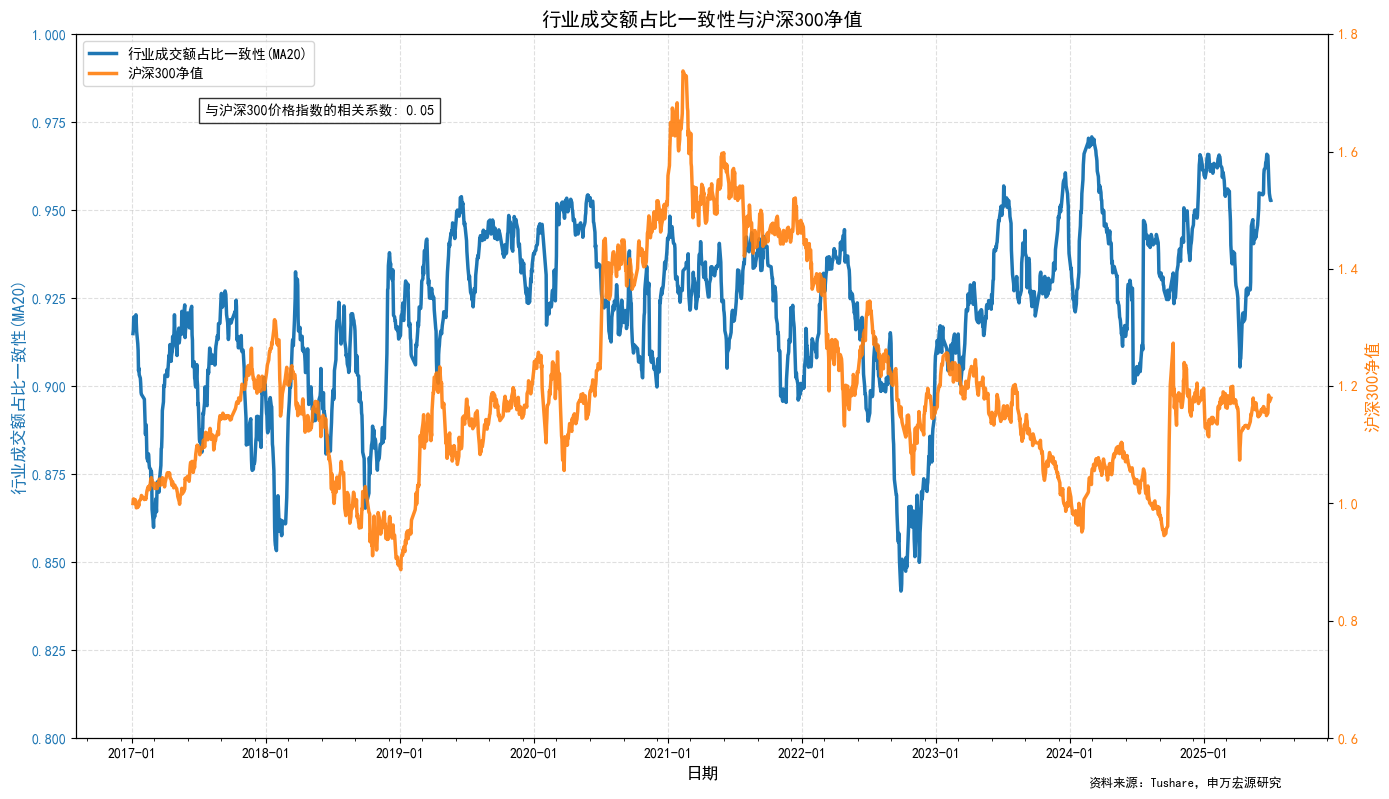

计算图5指标: 行业成交额占比波动水平...
图表已保存为: 行业成交额占比波动水平.png


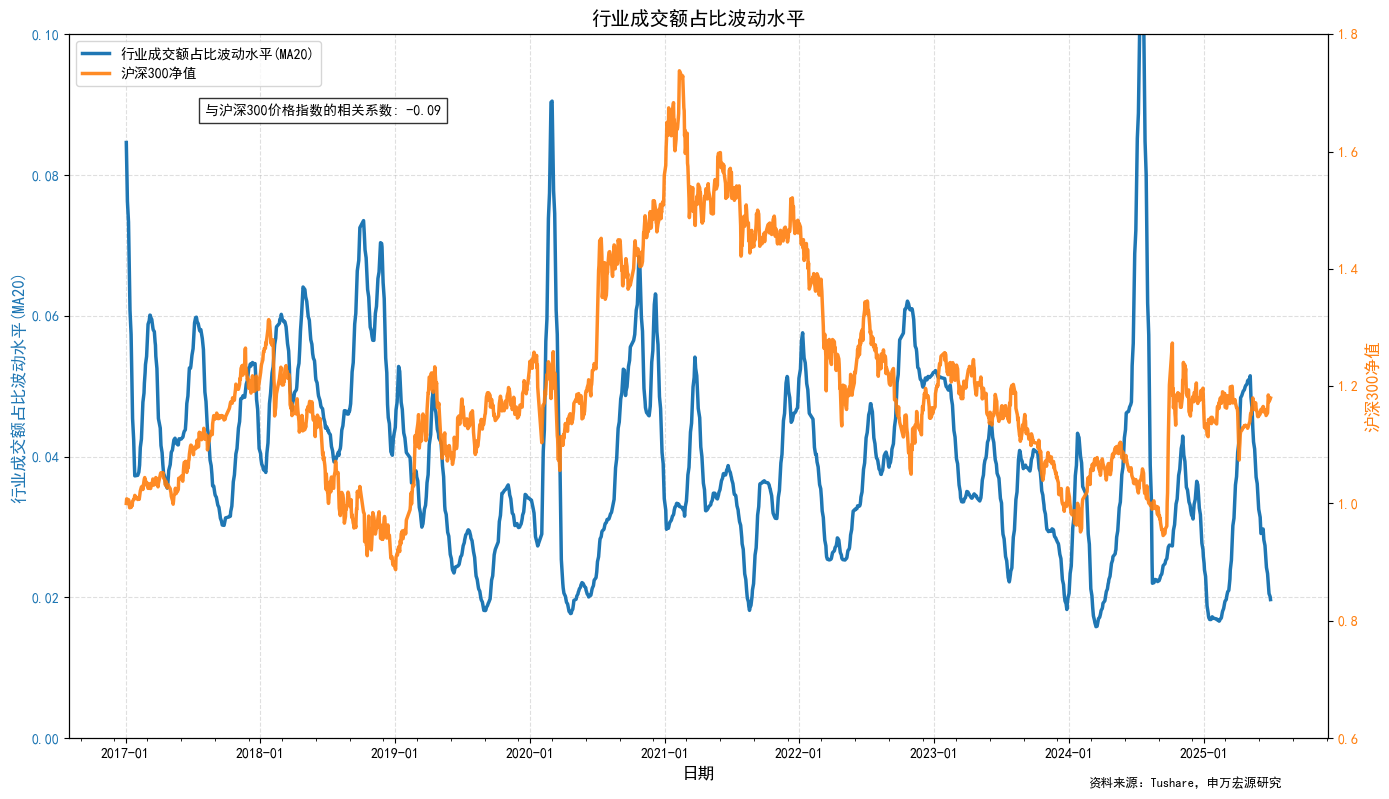

计算图6指标: 行业集中度...
从缓存加载数据: industry_concentration.pkl
图表已保存为: A股市场交易的行业集中度.png


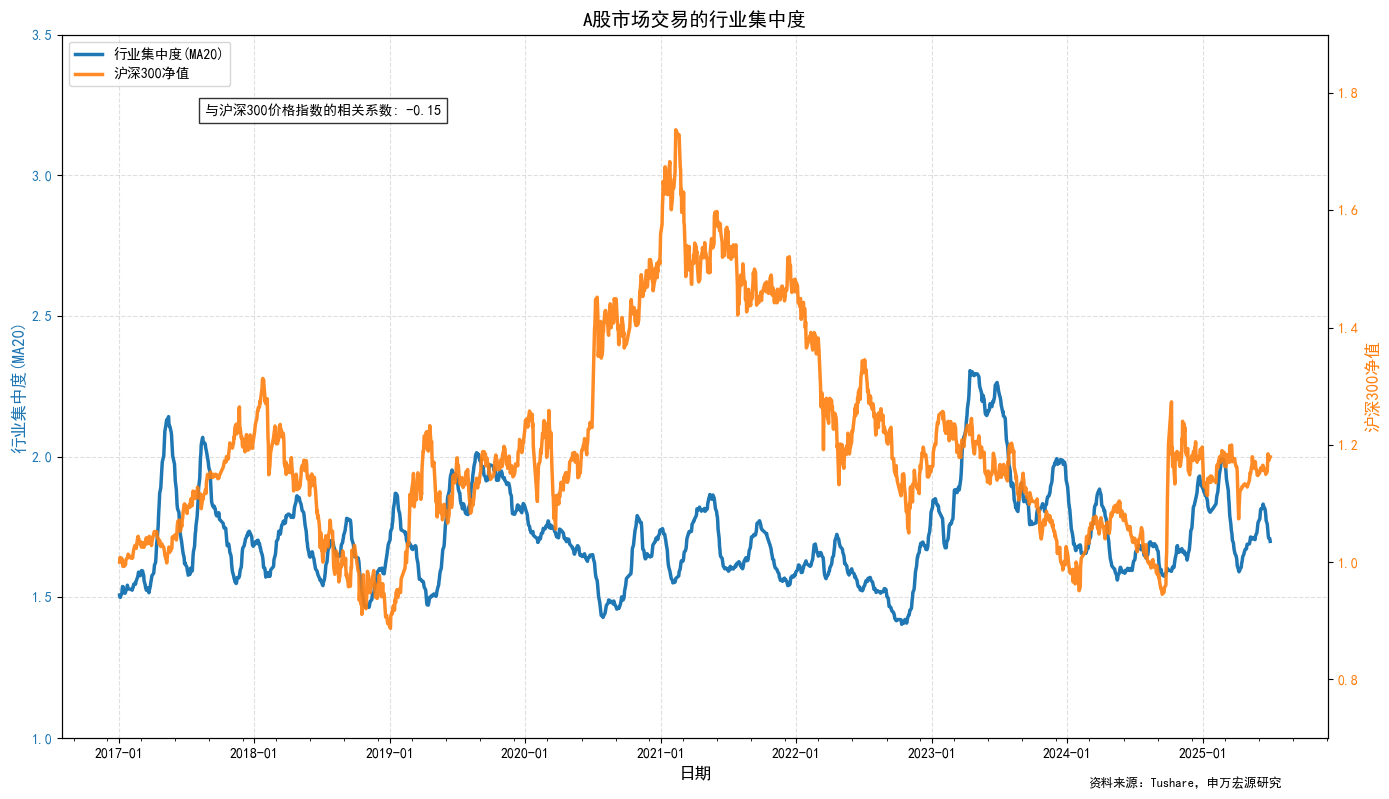

计算图7指标: 行业涨幅和成交额变化一致性...
从缓存加载数据: return_amt_correlation.pkl
图表已保存为: 行业涨幅和成交额变化一致性与沪深300净值.png


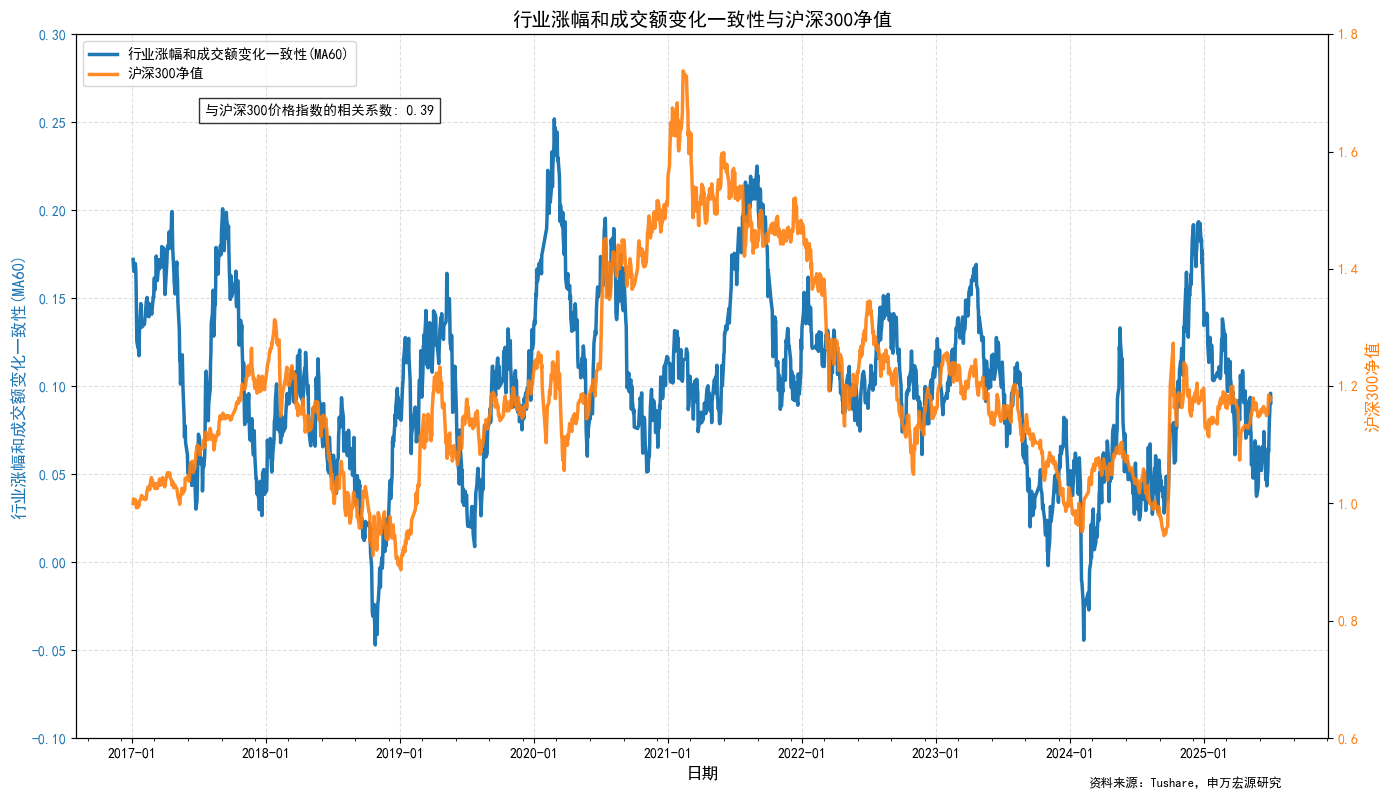

从缓存加载数据: gem_activity.pkl
图表已保存为: 创业板成交活跃度与沪深300净值.png


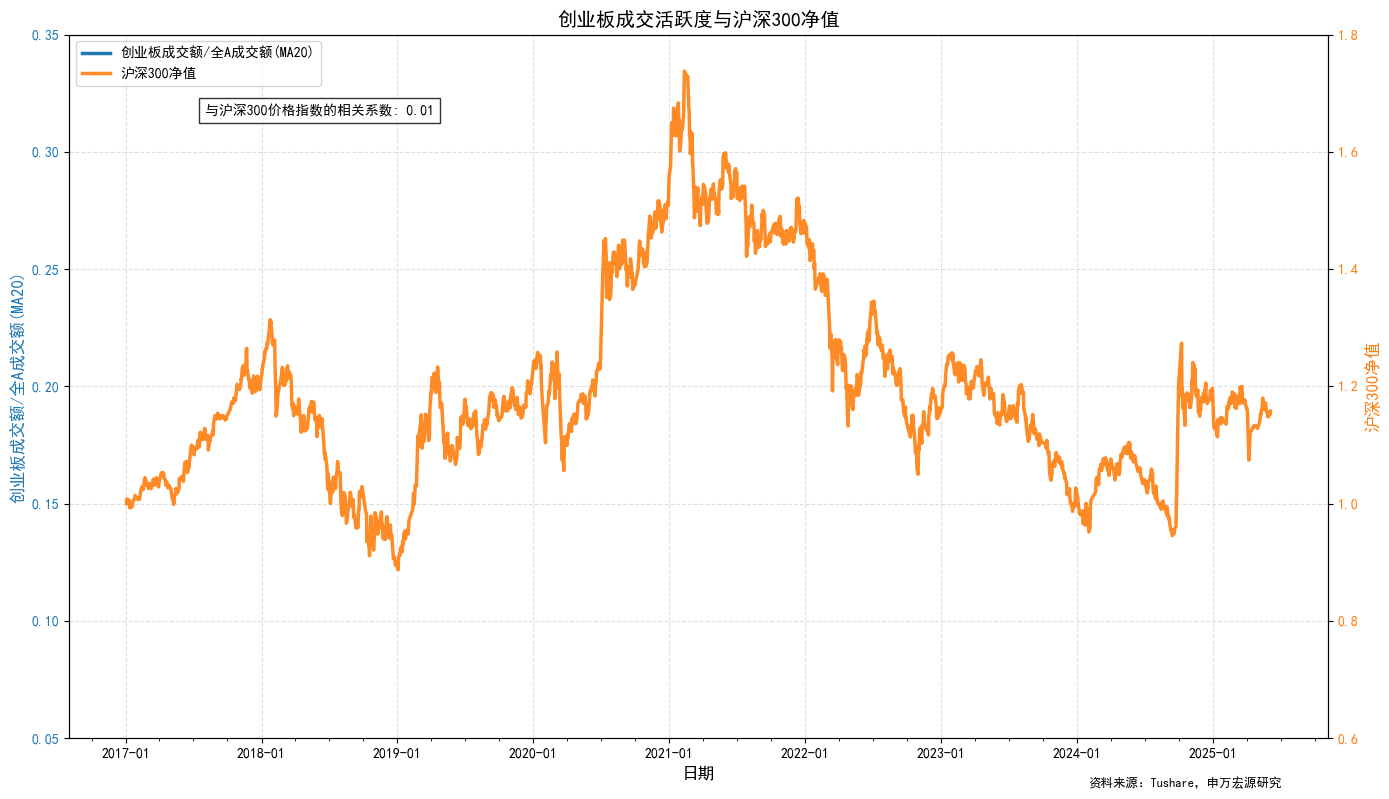

计算图10指标: 沪深300 RSI...
从缓存加载数据: hs300_rsi.pkl
图表已保存为: 沪深300_RSI与指数净值变化趋势.png


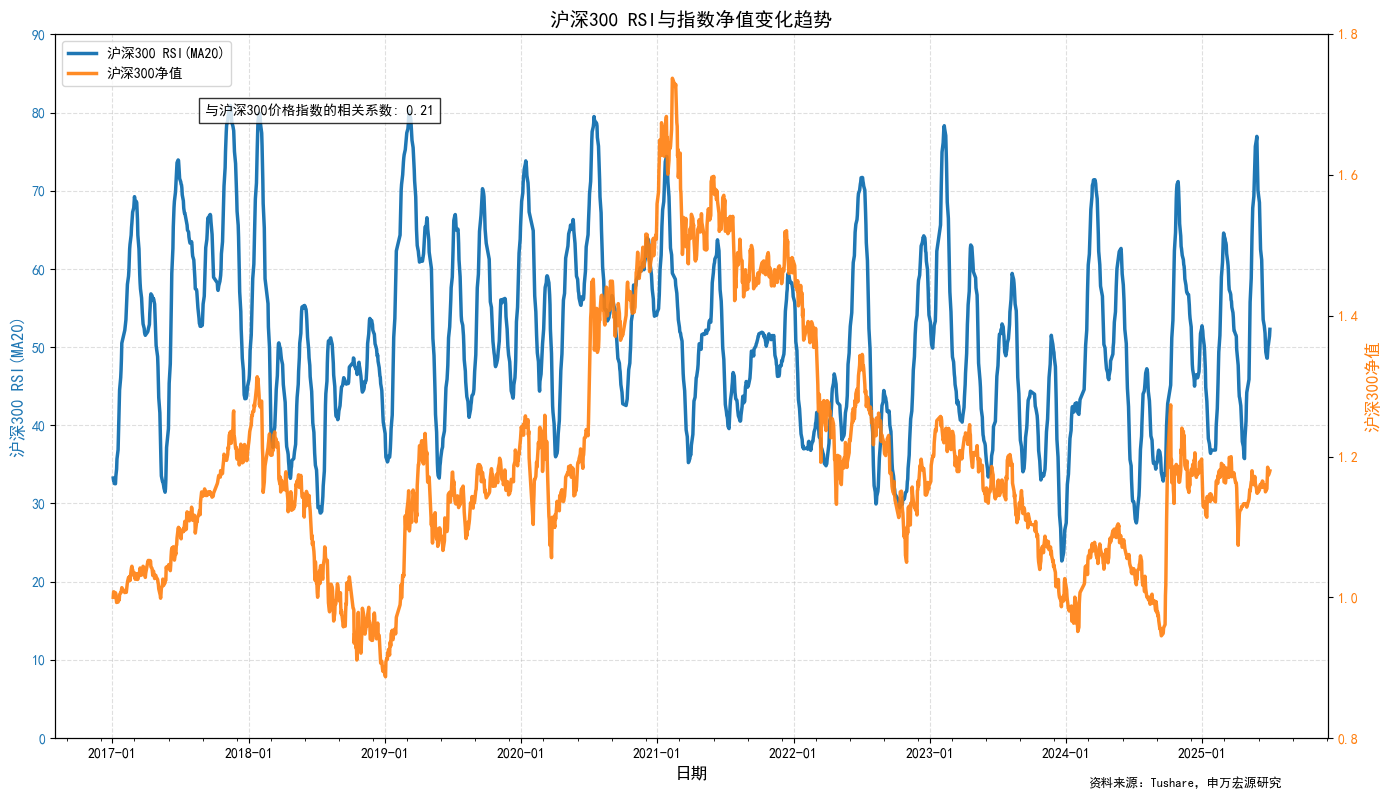

计算图11指标: 行业轮涨补涨程度...
从缓存加载数据: industry_rotation_corrected.pkl
图表已保存为: 行业轮涨补涨程度与指数净值变化趋势.png


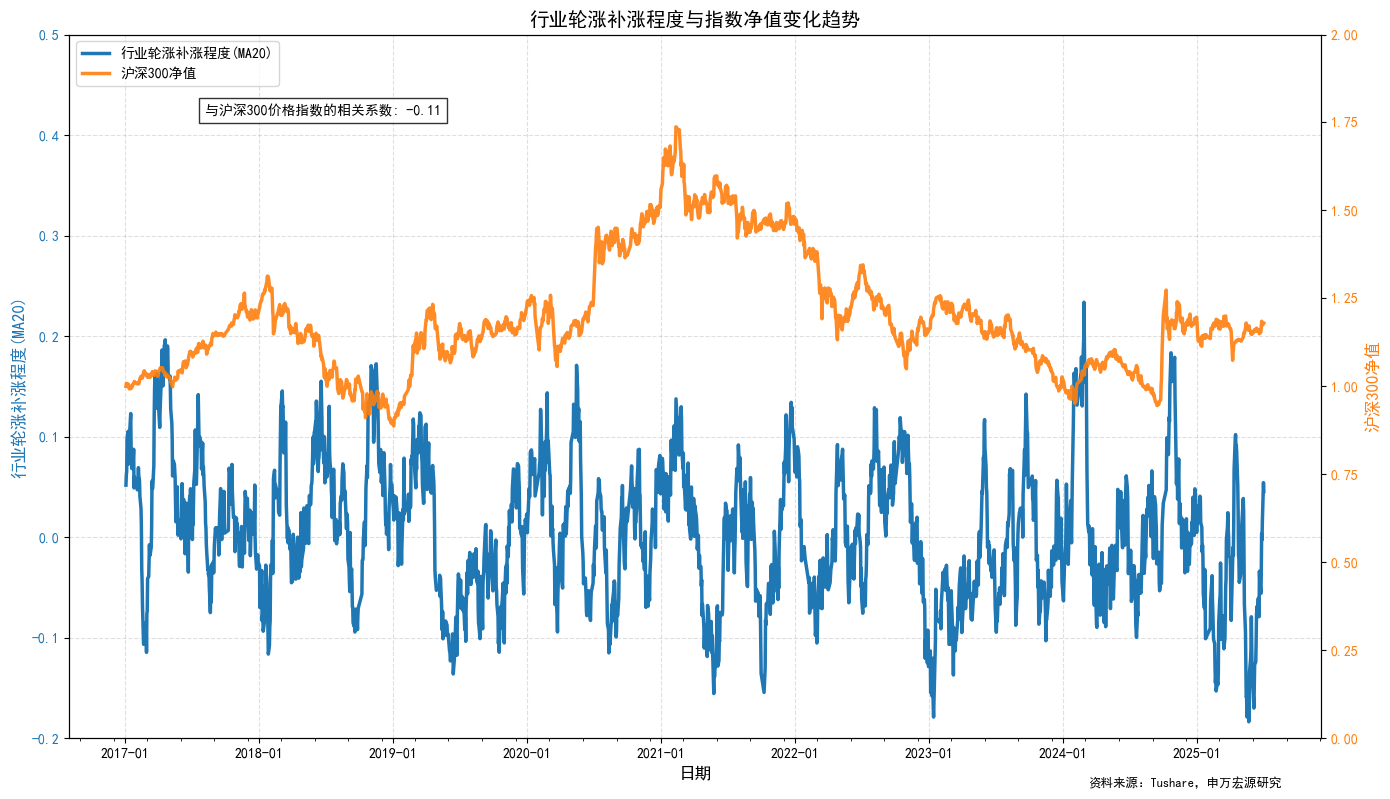

生成图15：300波指与标的价格...
从缓存加载数据: vix_300_20191223_20250626.pkl
图表已保存为: 300波指与标的价格.png


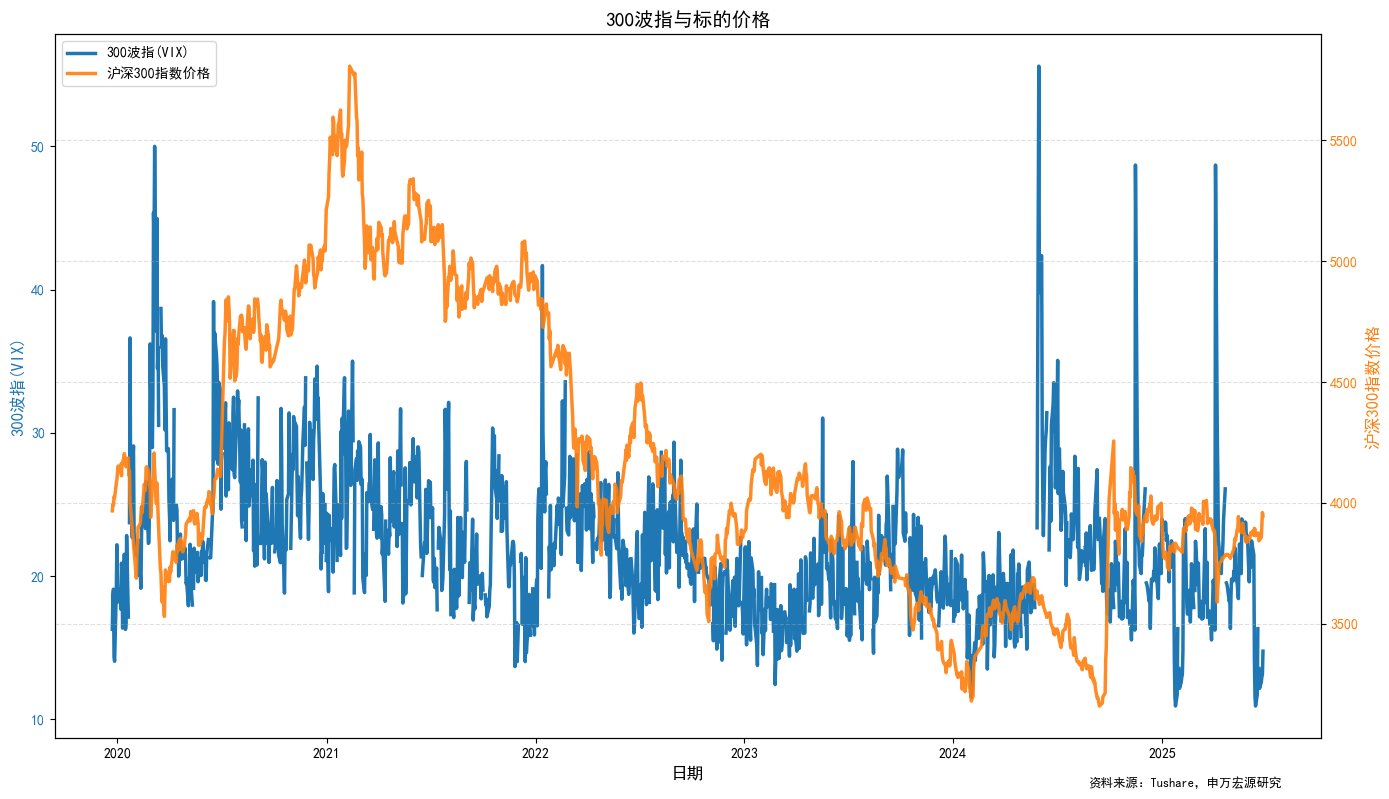

生成图17：300波指与标的价格3M滚动相关系数...


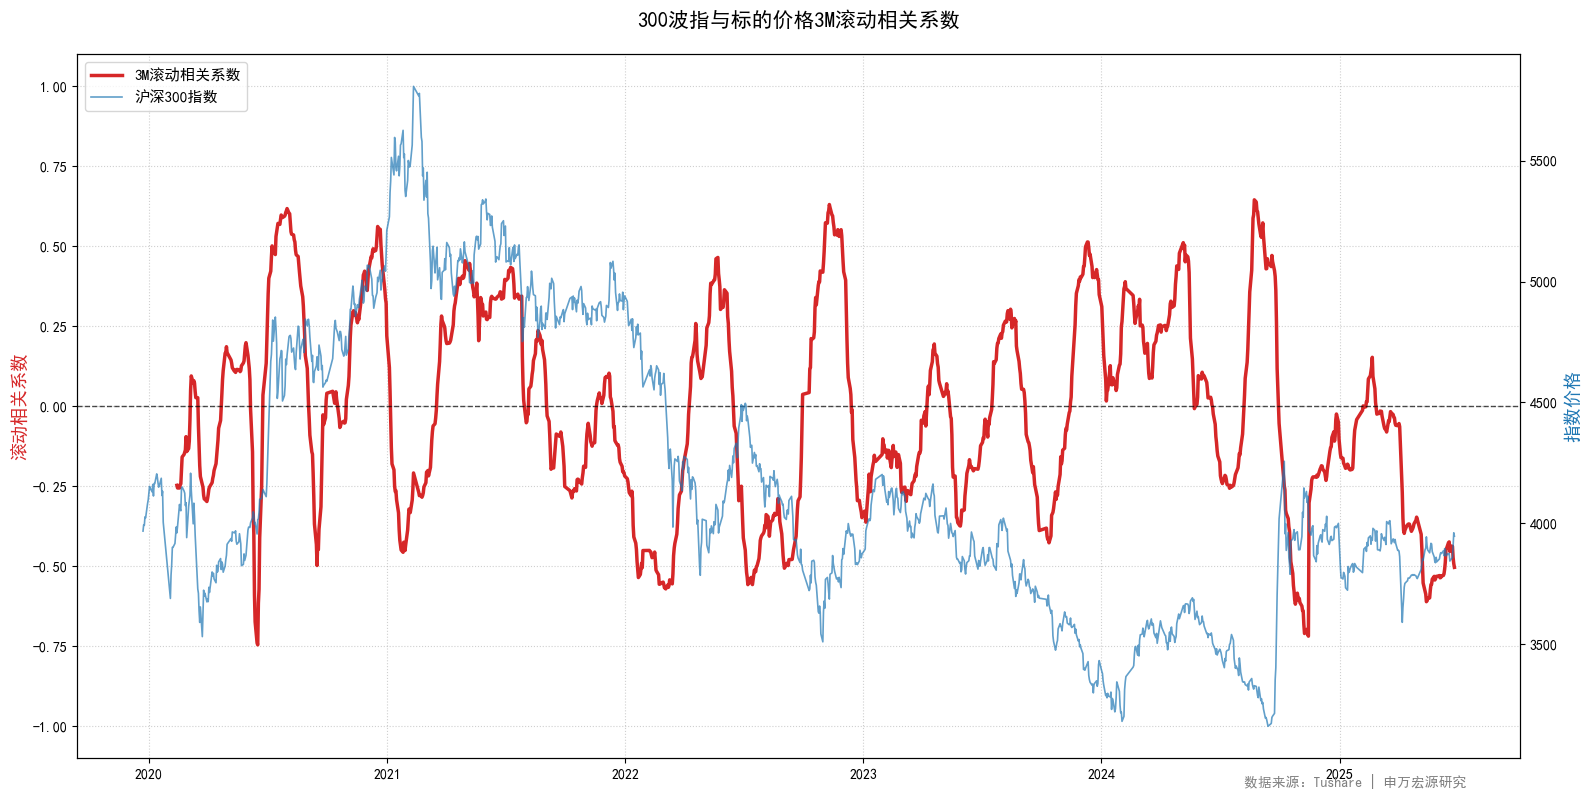

生成图18：中金所300指数PCR与沪深300指数...


ProxyError: HTTPConnectionPool(host='127.0.0.1', port=10809): Max retries exceeded with url: http://api.waditu.com/dataapi/index_daily/ (Caused by ProxyError('Cannot connect to proxy.', ConnectionResetError(10054, '远程主机强迫关闭了一个现有的连接。', None, 10054, None)))

In [19]:

# 主程序
def main():
    # 设置日期范围
    start_date = '20100101'
    end_date = current_date
    report_start_date = '20170103'
    report_end_date = current_date
    
    print(f"开始日期: {start_date}, 结束日期: {end_date}")
    
    # 1. 获取申万一级行业列表
    industry_codes, industry_names = get_sw_industry_list()
    if not industry_codes:
        return
    
    # 2. 获取行业日行情数据
    print("正在获取行业日行情数据...")
    industry_data = get_cached_data(
        "industry_data.pkl", 
        get_industry_daily, 
        industry_codes, start_date, end_date
    )
    if industry_data.empty:
        return
    
    # 3. 获取沪深300净值数据
    print("正在获取沪深300指数数据...")
    hs300 = get_cached_data(
        "hs300_data.pkl",
        get_hs300_data,
        start_date, end_date
    )
    if hs300.empty:
        return
    
    # 4. 计算各指标并绘制图表
    print("正在计算各指标并绘制图表...")
    
    # 图4：行业成交额占比一致性与沪深300净值
    print("计算图4指标: 行业成交额占比一致性...")
    corr_df, amt_corr_data = get_cached_data(
        "amt_correlation.pkl",
        calculate_amt_correlation,
        industry_data
    )
    if not corr_df.empty:
        merged_fig4 = pd.merge(corr_df, hs300, on='trade_date', how='left')
        corr_value_fig4 = calculate_correlation(merged_fig4, 'amt_corr_ma', 'close', report_start_date, report_end_date)
        plot_chart(
            corr_df, hs300, 
            title='行业成交额占比一致性与沪深300净值', 
            ylabel_left='行业成交额占比一致性(MA20)', 
            ylabel_right='沪深300净值',
            indicator_col='amt_corr_ma',  # 修正列名
            corr_value=corr_value_fig4,
            ylim_left=(0.8, 1.0),
            ylim_right=(0.6, 1.8),
            plot_start_date=report_start_date,
            plot_end_date=report_end_date
        )
    
    # 图5：行业成交额占比波动水平
    print("计算图5指标: 行业成交额占比波动水平...")
    if not corr_df.empty:
        merged_fig5 = pd.merge(corr_df, hs300, on='trade_date', how='left')
        corr_value_fig5 = calculate_correlation(merged_fig5, 'amt_corr_std_ma', 'close', report_start_date, report_end_date)
        plot_chart(
            corr_df, hs300, 
            title='行业成交额占比波动水平', 
            ylabel_left='行业成交额占比波动水平(MA20)', 
            ylabel_right='沪深300净值',
            indicator_col='amt_corr_std_ma',
            corr_value=corr_value_fig5,
            ylim_left=(0.00, 0.10),
            ylim_right=(0.6, 1.8),
            plot_start_date=report_start_date,
            plot_end_date=report_end_date
        )
        
    # 图6：A股市场交易的行业集中度
    print("计算图6指标: 行业集中度...")
    if amt_corr_data is not None and not amt_corr_data.empty and 'relative_amt' in amt_corr_data.columns:
        conc_df = get_cached_data(
            "industry_concentration.pkl",
            calculate_industry_concentration,
            amt_corr_data
        )
        if not conc_df.empty:
            merged_fig6 = pd.merge(conc_df, hs300, on='trade_date', how='left')
            corr_value_fig6 = calculate_correlation(merged_fig6, 'concentration_ma20', 'close', report_start_date, report_end_date)
            plot_chart(
                conc_df, hs300, 
                title='A股市场交易的行业集中度', 
                ylabel_left='行业集中度(MA20)', 
                ylabel_right='沪深300净值',
                indicator_col='concentration_ma20',
                corr_value=corr_value_fig6,
                ylim_left=(1.0, 3.5),
                ylim_right=(0.7, 1.9),
                plot_start_date=report_start_date,
                plot_end_date=report_end_date
            )
    
    # 图7：行业涨幅和成交额变化一致性与沪深300净值
    print("计算图7指标: 行业涨幅和成交额变化一致性...")
    return_amt_corr_df = get_cached_data(
        "return_amt_correlation.pkl",
        calculate_return_amt_correlation,
        industry_data
    )
    if not return_amt_corr_df.empty:
        merged_fig7 = pd.merge(return_amt_corr_df, hs300, on='trade_date', how='left')
        corr_value_fig7 = calculate_correlation(merged_fig7, 'return_amt_corr_ma60', 'close', report_start_date, report_end_date)
        plot_chart(
            return_amt_corr_df, hs300, 
            title='行业涨幅和成交额变化一致性与沪深300净值', 
            ylabel_left='行业涨幅和成交额变化一致性(MA60)', 
            ylabel_right='沪深300净值',
            indicator_col='return_amt_corr_ma60',
            corr_value=corr_value_fig7,
            ylim_left=(-0.1, 0.3),
            ylim_right=(0.6, 1.8),
            plot_start_date=report_start_date,
            plot_end_date=report_end_date
        )
        
        # 图8：创业板成交活跃度与沪深300净值
        gem_activity_df = get_cached_data(
            "gem_activity.pkl",
            calculate_gem_activity,
            start_date, end_date
        )
        if not gem_activity_df.empty:
            merged_fig8 = pd.merge(gem_activity_df, hs300, on='trade_date', how='inner')
            corr_value_fig8 = calculate_correlation(merged_fig8, 'gem_activity_ma20', 'close', report_start_date, report_end_date)
            plot_chart(
                gem_activity_df, 
                hs300, 
                title='创业板成交活跃度与沪深300净值', 
                ylabel_left='创业板成交额/全A成交额(MA20)', 
                ylabel_right='沪深300净值',
                indicator_col='gem_activity_ma20',
                corr_value=corr_value_fig8,
                ylim_left=(0.05, 0.35),
                ylim_right=(0.6, 1.8),
                plot_start_date=report_start_date,
                plot_end_date=report_end_date
            )

    # # 图9：融资余额占自由流通市值比
    # print("计算图9指标: 融资余额占自由流通市值比...")
    # margin_ratio_df = calculate_margin_ratio(start_date, end_date)
    # merged = pd.merge(margin_ratio_df, hs300, on='trade_date', how='left')
    # corr_value_fig9 = calculate_correlation(merged, 'margin_ratio_ma60', 'close', report_start_date, report_end_date)
    # plot_chart(
    #     margin_ratio_df, hs300, 
    #     title='融资余额占自由流通市值比', 
    #     ylabel_left='融资余额占比(MA60)', 
    #     ylabel_right='沪深300净值',
    #     indicator_col='margin_ratio_ma60',
    #     corr_value=corr_value_fig9,
    #     ylim_left=(0.035, 0.048),
    #     ylim_right=(0.6, 1.8)
    # )
    
        
    # 图10：沪深300 RSI与指数净值变化趋势
    print("计算图10指标: 沪深300 RSI...")
    hs300_rsi_df = get_cached_data(
        "hs300_rsi.pkl",
        calculate_hs300_rsi,
        start_date, end_date
    )
    if not hs300_rsi_df.empty:
        merged_fig10 = pd.merge(hs300_rsi_df, hs300, on='trade_date', how='left')
        corr_value_fig10 = calculate_correlation(merged_fig10, 'rsi_ma20', 'close', report_start_date, report_end_date)
        plot_chart(
            hs300_rsi_df, hs300, 
            title='沪深300 RSI与指数净值变化趋势', 
            ylabel_left='沪深300 RSI(MA20)', 
            ylabel_right='沪深300净值',
            indicator_col='rsi_ma20',
            corr_value=corr_value_fig10,
            ylim_left=(0, 90),
            ylim_right=(0.8, 1.8),
            plot_start_date=report_start_date,
            plot_end_date=report_end_date
        )
        
    # 图11：行业轮涨补涨程度与指数净值变化趋势
    print("计算图11指标: 行业轮涨补涨程度...")
    rotation_df = get_cached_data(
        "industry_rotation_corrected.pkl",
        calculate_industry_rotation,
        industry_data
    )
    if not rotation_df.empty:
        merged_fig11 = pd.merge(rotation_df, hs300, on='trade_date', how='left')
        corr_value_fig11 = calculate_correlation(merged_fig11, 'rotation_corr_ma20', 'close', report_start_date, report_end_date)
        plot_chart(
            rotation_df, hs300, 
            title='行业轮涨补涨程度与指数净值变化趋势', 
            ylabel_left='行业轮涨补涨程度(MA20)', 
            ylabel_right='沪深300净值',
            indicator_col='rotation_corr_ma20',
            corr_value=corr_value_fig11,
            ylim_left=(-0.2, 0.5),
            ylim_right=(0, 2),
            plot_start_date=report_start_date,
            plot_end_date=report_end_date
        )

    # 设置日期范围（期权数据从2019年12月开始）
    start_date = '20191223'
    end_date = current_date
    end_date = '20250626'
   # 图14：50ETF波指与标的价格
    print("生成图14：50ETF波指与标的价格...")
    vix_50 = get_50etf_vix_data(start_date, end_date)
    etf_50 = get_50etf_price(start_date, end_date)
    
    if not vix_50.empty and not etf_50.empty:
        # 确保日期格式一致
        vix_50['trade_date'] = pd.to_datetime(vix_50['trade_date'])
        etf_50['trade_date'] = pd.to_datetime(etf_50['trade_date'])
        
        # 统一按升序排序
        vix_50 = vix_50.sort_values('trade_date')
        etf_50 = etf_50.sort_values('trade_date')
        
        # 确保日期范围一致
        start = max(vix_50['trade_date'].min(), etf_50['trade_date'].min())
        end = min(vix_50['trade_date'].max(), etf_50['trade_date'].max())
        
        vix_50 = vix_50[(vix_50['trade_date'] >= start) & (vix_50['trade_date'] <= end)]
        etf_50 = etf_50[(etf_50['trade_date'] >= start) & (etf_50['trade_date'] <= end)]
        
        # 再次检查数据是否为空
        if not vix_50.empty and not etf_50.empty:
            plot_dual_axis(
                vix_50, etf_50,
                title='50ETF波指与标的价格',
                ylabel1='50ETF波指(VIX)',
                ylabel2='50ETF价格',
                col1='vix',
                col2='price_50etf'
            )
        else:
            print("警告：日期对齐后数据为空，无法绘制图表")
    else:
        print("警告：获取到的VIX或ETF数据为空，无法绘制图表")

    # 图15：300波指与标的价格
    print("生成图15：300波指与标的价格...")
    vix_300 = get_300_vix_data(start_date, end_date)
    hs300_price = get_hs300_index(start_date, end_date)
    
    if not vix_300.empty and not hs300_price.empty:
        # 确保日期列是datetime类型
        vix_300['trade_date'] = pd.to_datetime(vix_300['trade_date'])
        hs300_price['trade_date'] = pd.to_datetime(hs300_price['trade_date'])
        
        # 统一按升序排序
        vix_300 = vix_300.sort_values('trade_date')
        hs300_price = hs300_price.sort_values('trade_date')
        
        # 确保日期范围一致
        start = max(vix_300['trade_date'].min(), hs300_price['trade_date'].min())
        end = min(vix_300['trade_date'].max(), hs300_price['trade_date'].max())
        
        vix_300 = vix_300[(vix_300['trade_date'] >= start) & (vix_300['trade_date'] <= end)]
        hs300_price = hs300_price[(hs300_price['trade_date'] >= start) & (hs300_price['trade_date'] <= end)]
        
        # 再次检查数据是否为空
        if not vix_300.empty and not hs300_price.empty:
            plot_dual_axis(
                vix_300, hs300_price,
                title='300波指与标的价格',
                ylabel1='300波指(VIX)',
                ylabel2='沪深300指数价格',
                col1='vix',
                col2='price_hs300'
            )
        else:
            print("警告：日期对齐后数据为空，无法绘制图表")
    else:
        print("警告：获取到的VIX或指数数据为空，无法绘制图表")

    # 图16：50ETF波指与标的价格3M滚动相关系数
    print("生成图16：50ETF波指与标的价格3M滚动相关系数...")
    if not vix_50.empty and not etf_50.empty:
        # 合并数据
        merged_50 = pd.merge(vix_50, etf_50, on='trade_date').sort_values('trade_date')
        # 处理缺失值
        merged_50 = merged_50.dropna(subset=['vix', 'price_50etf']) 

        # 计算滚动相关系数（动态窗口）
        window_size = min(63, len(merged_50))
        merged_50['roll_corr'] = merged_50['vix'].rolling(window=window_size).corr(merged_50['price_50etf'])

        # 数据检查
        print("有效数据点:", len(merged_50['roll_corr'].dropna()))
        print("相关系数范围:", merged_50['roll_corr'].min(), merged_50['roll_corr'].max())
        
        # 创建图表
        fig, ax1 = plt.subplots(figsize=(16, 8))
        
        # 红色相关系数线（左轴）
        ax1.plot(merged_50['trade_date'], merged_50['roll_corr'], 
                color='tab:red', linewidth=3, label='3M滚动相关系数')
        ax1.set_ylabel('滚动相关系数', fontsize=13, color='tab:red')
        ax1.tick_params(axis='y', labelcolor='tab:red')
        ax1.set_ylim(-1.1, 1.1)  # 固定相关系数范围
        ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.7)
        
        # 蓝色价格线（右轴）
        ax2 = ax1.twinx()
        ax2.plot(merged_50['trade_date'], merged_50['price_50etf'], 
                color='tab:blue', linewidth=1.5, alpha=0.8, label='50ETF价格')
        ax2.set_ylabel('50ETF价格', fontsize=13, color='tab:blue')
        
        # 图例合并
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11)
        
        # 其他格式设置
        plt.title('50ETF波指与标的价格3M滚动相关系数', fontsize=15, pad=20)
        ax1.grid(True, linestyle=':', alpha=0.6)
        plt.figtext(0.85, 0.01, '数据来源：Tushare | 申万宏源研究', ha='center', fontsize=10)
        plt.tight_layout()
        
        plt.savefig('50ETF波指与标的价格3M滚动相关系数.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # 图17：300波指与标的价格3M滚动相关系数
    print("生成图17：300波指与标的价格3M滚动相关系数...")
    if not vix_300.empty and not hs300_price.empty:
        # 数据合并与预处理
        merged_300 = pd.merge(vix_300, hs300_price, on='trade_date').sort_values('trade_date')
        
        # 动态计算窗口（63个交易日≈3个月）
        window_size = min(63, len(merged_300) - 1)  # 确保至少window_size+1个数据点
        
        # 计算滚动相关系数（带容错处理）
        merged_300['roll_corr'] = merged_300['vix'].rolling(
            window=window_size,
            min_periods=max(3, int(window_size*0.5))  # 至少50%数据点
        ).corr(merged_300['price_hs300'])
        
        # 数据有效性检查
        valid_corr = merged_300['roll_corr'].dropna()
        if len(valid_corr) == 0:
            print("警告：未能计算出有效相关系数")
        else:
            # 创建双坐标轴图表
            fig, ax1 = plt.subplots(figsize=(16, 8))
            
            # 红色相关系数线（左轴）
            ax1.plot(merged_300['trade_date'], merged_300['roll_corr'], 
                    color='tab:red', linewidth=2.5, label='3M滚动相关系数')
            ax1.set_ylabel('滚动相关系数', fontsize=13, color='tab:red')
            ax1.set_ylim(-1.1, 1.1)  # 固定相关系数范围
            ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.7)
            ax1.grid(True, linestyle=':', alpha=0.6)
            
            # 蓝色价格线（右轴）
            ax2 = ax1.twinx()
            ax2.plot(merged_300['trade_date'], merged_300['price_hs300'], 
                    color='tab:blue', linewidth=1.2, alpha=0.7, label='沪深300指数')
            ax2.set_ylabel('指数价格', fontsize=13, color='tab:blue')
            
            # 图表装饰
            plt.title('300波指与标的价格3M滚动相关系数', fontsize=15, pad=20, fontweight='bold')
            
            # 合并图例
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11)
            
            # 添加数据来源
            plt.figtext(0.85, 0.01, '数据来源：Tushare | 申万宏源研究', 
                    ha='center', fontsize=10, color='gray')
            
            plt.tight_layout()
            plt.savefig('300波指与标的价格3M滚动相关系数.png', 
                    dpi=300, bbox_inches='tight', facecolor='white')
            plt.show()

    # 图18：中金所300指数PCR与沪深300指数
    print("生成图18：中金所300指数PCR与沪深300指数...")
    
    # 获取PCR数据
    option_data = get_300_option_data_corrected(start_date, end_date)
    
    # 获取沪深300指数数据
    hs300_data = get_hs300_index(start_date, end_date)
    
    if option_data.empty or hs300_data.empty:
        print("缺少必要数据，无法绘制图18")
        return
    
    # 数据处理
    option_data['trade_date'] = pd.to_datetime(option_data['trade_date'])
    hs300_data['trade_date'] = pd.to_datetime(hs300_data['trade_date'])
    
    # 创建双轴图表
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # PCR数据（左轴）
    color = 'tab:blue'
    ax1.set_xlabel('日期', fontsize=12)
    ax1.set_ylabel('PCR(20日均线)', color=color, fontsize=12)
    ax1.plot(option_data['trade_date'], option_data['pcr_ma20'], 
             color=color, linewidth=2, label='PCR(20日均线)')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # 沪深300指数（右轴）
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('沪深300指数', color=color, fontsize=12)
    ax2.plot(hs300_data['trade_date'], hs300_data['price_hs300'], 
             color=color, linewidth=1.5, alpha=0.7, label='沪深300指数')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # 图表装饰
    plt.title('中金所300指数PCR(20日均线)与沪深300指数', fontsize=14, pad=15)
    fig.tight_layout()
    plt.figtext(0.85, 0.01, '数据来源：Tushare | 申万宏源研究', ha='center', fontsize=9)
    
    # 合并图例
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    
    # 保存图表
    plt.savefig('图18_中金所300指数PCR与沪深300指数.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("图18已保存")

    # 图19：中金所300 PCR与认沽、认购成交量变化情况
    print("生成图19：中金所300 PCR与认沽、认购成交量变化情况...")

    # 准备数据
    option_data['call_vol_ma20'] = option_data['call_vol'].rolling(window=20).mean()
    option_data['put_vol_ma20'] = option_data['put_vol'].rolling(window=20).mean()
    option_data['total_vol_ma20'] = option_data['call_vol_ma20'] + option_data['put_vol_ma20']

    fig, ax1 = plt.subplots(figsize=(14, 7))

    # 认购成交量（左轴）
    color = 'tab:red'
    ax1.set_xlabel('日期', fontsize=12)
    ax1.set_ylabel('成交量(20日均线, 万手)', color='k', fontsize=12)
    ax1.plot(option_data['trade_date'], option_data['call_vol_ma20'], 
            color=color, linewidth=2, label='认购成交量')
    ax1.plot(option_data['trade_date'], option_data['put_vol_ma20'], 
            color='tab:orange', linewidth=2, label='认沽成交量')
    ax1.plot(option_data['trade_date'], option_data['total_vol_ma20'], 
            color='tab:green', linewidth=2, label='总成交量')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend(loc='upper left')

    # PCR数据（右轴）
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('PCR(20日均线)', color=color, fontsize=12)
    ax2.plot(option_data['trade_date'], option_data['pcr_ma20'], 
            color=color, linewidth=2, alpha=0.8, label='PCR(20日均线)')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    # 图表装饰
    plt.title('中金所300 PCR与认沽、认购成交量变化情况', fontsize=14, pad=15)
    fig.tight_layout()
    plt.figtext(0.85, 0.01, '数据来源：Tushare | 申万宏源研究', ha='center', fontsize=9)

    # 保存图表
    plt.savefig('图19_中金所300PCR与认沽认购成交量变化.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("图19已保存")

    # 图20：中金所300波指与认沽、认购成交量之和趋势高度一致
    print("生成图20：中金所300波指与认沽、认购成交量之和趋势高度一致...")

    # 确保option_data包含VIX数据
    if 'vix' not in option_data.columns:
        # 获取VIX数据（假设有获取VIX数据的函数）
        vix_data = get_300_vix_data(start_date, end_date)
        # 转换vix_300的trade_date为datetime
        if 'trade_date' in vix_data.columns:
            vix_data['trade_date'] = pd.to_datetime(vix_data['trade_date'], errors='coerce')
            
        # 确保option_data的trade_date也是datetime
        if 'trade_date' in option_data.columns:
            option_data['trade_date'] = pd.to_datetime(option_data['trade_date'], errors='coerce')
        
        # 合并VIX数据到option_data
        option_data = pd.merge(
            option_data, 
            vix_data[['trade_date', 'vix']],
            on='trade_date',
            how='left'
        )
        
        print(f"已合并VIX数据，新增{len(vix_data)}条记录")

    # 创建20日均线列（带容错处理）
    if 'vix' in option_data.columns:
        # 数据清洗：转换数据类型
        option_data['vix'] = pd.to_numeric(option_data['vix'], errors='coerce')
        
        # 缺失值处理
        option_data['vix'].fillna(method='ffill', inplace=True)
        option_data['vix'].fillna(method='bfill', inplace=True)
        
        # 计算20日均线
        option_data['vix_ma20'] = option_data['vix'].rolling(
            window=20,
            min_periods=5  # 最小5个数据点
        ).mean()
        
        print("成功创建vix_ma20列")
    else:
        print("错误：option_data中缺少vix列")
        return  # 提前退出

    fig, ax1 = plt.subplots(figsize=(14, 7))

    # 成交量之和（左轴）
    color = 'tab:blue'
    ax1.set_xlabel('日期', fontsize=12)
    ax1.set_ylabel('认沽+认购成交量(20日均线, 万手)', color=color, fontsize=12)
    ax1.plot(option_data['trade_date'], option_data['total_vol_ma20'], 
            color=color, linewidth=2, label='成交量之和')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle='--', alpha=0.6)

    # VIX波指（右轴）
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('300波指(20日均线)', color=color, fontsize=12)
    ax2.plot(option_data['trade_date'], option_data['vix_ma20'], 
            color=color, linewidth=2, alpha=0.8, label='300波指')
    ax2.tick_params(axis='y', labelcolor=color)

    # 图表装饰
    plt.title('中金所300波指与认沽、认购成交量之和趋势高度一致', fontsize=14, pad=15)
    fig.tight_layout()
    plt.figtext(0.85, 0.01, '数据来源：Tushare | 申万宏源研究', ha='center', fontsize=9)

    # 合并图例
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    # 保存图表
    plt.savefig('图20_中金所300波指与成交量之和趋势.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("图20已保存")

    # 图21：PCR和VIX与标的价格之间的相关性具有反向关系
    print("生成图21：PCR和VIX与标的价格之间的相关性具有反向关系...")

    # 准备数据 - 计算3个月滚动相关系数
    merged_data = pd.merge(option_data, hs300_data, on='trade_date', how='inner')
    merged_data['pcr_ma'] = merged_data['pcr_ma20'].rolling(window=20).mean()
    merged_data['vix_price_corr'] = merged_data['vix_ma20'].rolling(window=66).corr(merged_data['price_hs300'])

    fig, ax1 = plt.subplots(figsize=(14, 7))

    # 相关系数曲线
    ax1.set_xlabel('日期', fontsize=12)
    ax1.set_ylabel('相关系数', color='k', fontsize=12)
    ax1.plot(merged_data['trade_date'], merged_data['vix_price_corr'], 
            color='tab:blue', linewidth=2, label='VIX与标的价格相关系数')
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend(loc='upper left')

    # 沪深300指数（右轴）
    ax2 = ax1.twinx()
    ax2.plot(merged_data['trade_date'], merged_data['pcr_ma'], 
            color='tab:red', linewidth=2, label='PCR-ma')
    ax2.tick_params(axis='y', labelcolor=color)

    # 图表装饰
    plt.title('PCR和VIX与标的价格之间的相关性具有反向关系', fontsize=14, pad=15)
    fig.tight_layout()
    plt.figtext(0.85, 0.01, '数据来源：Tushare | 申万宏源研究 | 窗口:3个月(66个交易日)', ha='center', fontsize=9)

    # 保存图表
    plt.savefig('图21_PCR和VIX与标的价格相关性关系.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("图21已保存")

    print("所有图表生成完成！")

if __name__ == '__main__':
    main()